# Modeling

In this notebook we
1. Load '../Data/data_eda.csv' which is the output of exploratory data analysis.
2. Apply different model to predict Airbnb listing price.

### Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 8)
sns.set_palette(palette)

### Load Data

In [2]:
df = pd.read_csv('../Data/data_eda.csv')
df.head()

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio
0,85.0,81,14,0,0,4,1.0,1.0,1.0,4,2,1,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
1,150.0,81,14,0,0,4,1.0,1.0,1.0,4,1,2,40.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.2,2.444444
3,100.0,81,14,0,0,3,1.0,0.0,2.0,4,1,0,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",6.0,3.000000
4,450.0,81,14,9,0,6,2.0,3.0,3.0,4,6,2,125.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.0,3.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
price                              3818 non-null float64
neighbourhood_cleansed             3818 non-null int64
zipcode                            3818 non-null int64
property_type                      3818 non-null int64
room_type                          3818 non-null int64
accommodates                       3818 non-null int64
bathrooms                          3818 non-null float64
bedrooms                           3818 non-null float64
beds                               3818 non-null float64
bed_type                           3818 non-null int64
guests_included                    3818 non-null int64
cancellation_policy                3818 non-null int64
cleaning_fee                       3818 non-null float64
latitude_longitude_bin             3818 non-null int64
neighbourhood_cleansed_reverted    3818 non-null object
shapes                             3818 non-null object
a

In the data we have 17 features, 1 target. Total 3818 data points.

### Prepare functions for Plotting

In [4]:
def get_sub_plots(n_total_cols, n_cols, label_font_size = 14, tick_font_size = 13):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows,
                             ncols = n_cols,
                             squeeze = False)
    
    
    fig.set_size_inches(10 * n_cols, 8 * n_rows)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])

    axes = axes.flatten()
    
    for ax in axes:
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)

### Explore Data & Engineer Features

Check the price distribution with and without taking log.

In [5]:
def plot_ori_vs_log_comparison(x, xlabel, n_total_cols = 2, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    style = dict(size = fontsize, color = 'gray')
    
    x = pd.Series(x, name = xlabel)
    log_x = pd.Series(np.log(x), name = 'Taking log on ' + xlabel)

    sns.distplot(x, kde = False, ax = axes[0])
    axes[0].text(600, 550, 'Skew = ' + str(x.skew()), **style)
    axes[0].set_title('Histogram of ' + xlabel, fontsize = fontsize)
    axes[0].set_xlabel(xlabel, fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.distplot(log_x, kde = False, ax = axes[1])
    axes[1].text(5.5, 280, 'Skew = ' + str(log_x.skew()), **style)
    axes[1].set_title('Histogram of ' + xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_xlabel(xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_ylabel('Count', fontsize = fontsize)
    
    fig.tight_layout()    
    plt.show()

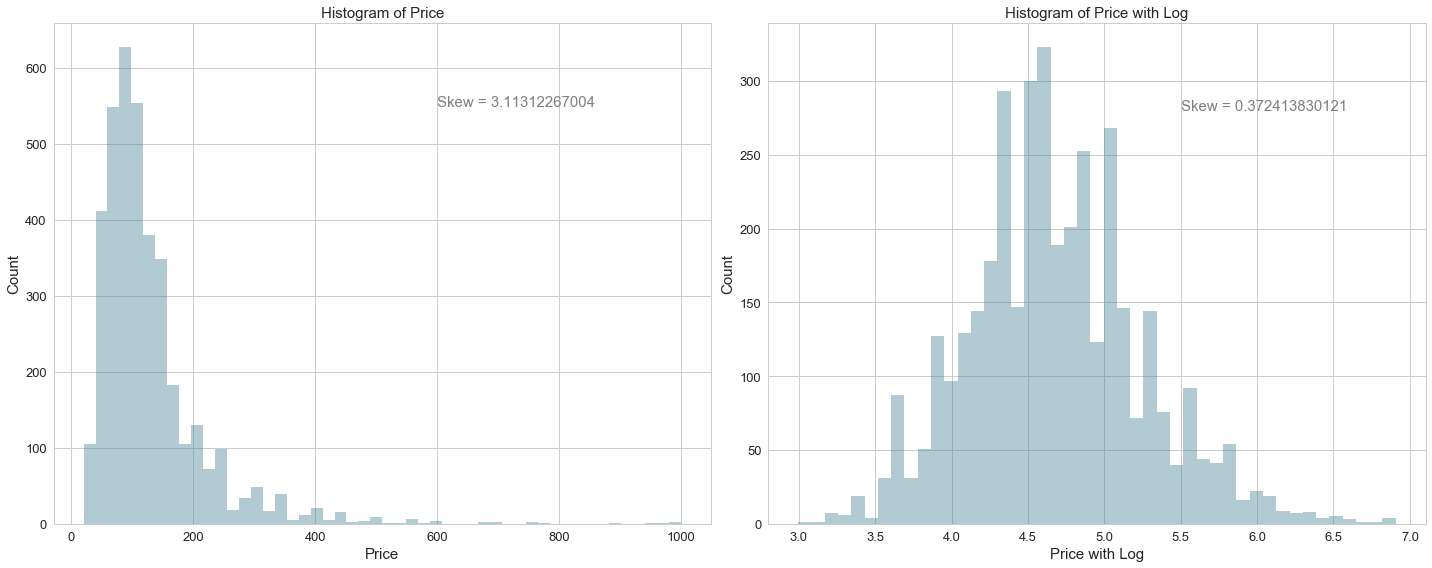

In [6]:
plot_ori_vs_log_comparison(df.price, 'Price')

Looks like taking log can make it distribute more normally & skew is much improved.

### Prepare functions for Scoring & Reporting

Here we use mean squared error (MSE) / root mean squared error (RMSE) for scoring.

We also plot
1. Histogram of predited y.
2. Scatter plot of Actual vs. Predicted y
3. Residual plot
4. HIstogram of Residuals

In [7]:
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.metrics import mean_squared_error

def plot_summary(y_test, y_pred, n_total_cols = 4, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    
    sns.distplot(y_pred, kde = False, ax = axes[0])
    axes[0].set_title('Histogram of predicted y', fontsize = fontsize)
    axes[0].set_xlabel('Pridected y', fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.regplot(y_test, y_pred, fit_reg = False, ax = axes[1])
    axes[1].set_title('Actual y vs. Predicted y', fontsize = fontsize)
    axes[1].set_xlabel('Actual y', fontsize = fontsize)
    axes[1].set_ylabel('Predicted y', fontsize = fontsize)
    
    sns.regplot(y_pred, y_test - y_pred, fit_reg = False, ax = axes[2])
    axes[2].set_title('Residual Plot', fontsize = fontsize)
    axes[2].set_xlabel('Predicted y', fontsize = fontsize)
    axes[2].set_ylabel('Residuals', fontsize = fontsize)
    
    sns.distplot(y_test - y_pred, kde = False, ax = axes[3])
    axes[3].set_title('Histogram of Residuals', fontsize = fontsize)
    axes[3].set_xlabel('Residuals', fontsize = fontsize)
    axes[3].set_ylabel('Count', fontsize = fontsize)
        
    fig.tight_layout()    
    plt.show()
    
def score_and_plot(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    
    print ('    MSE is: ', mse)
    print ('    RMSE is: ', rmse)

    plot_summary(y_test, y_pred)
    
    return rmse

### Prepare functions for Modeling

#### We will first try the following models:
1. K-Nearest Neighbors
2. Linear Regression
3. Ridge Regression
4. Lasso Regression
5. Random Forest

#### Train-Test-Split, Cross-Validation & Standardization
We also use train_test_split to do train-test split, GridSearchCV to do cross-validation & use StandardScaler to standardize the data.

BTW as in previous plot we can see that taking log can make the target distribute more normally, we add one more argument, take log (or not), to check if it can give better results.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

Models = ['KNN', 'Linear', 'Ridge', 'Lasso', 'RandomForest']
Linear_Models = ['Linear', 'Ridge', 'Lasso']

def model(model_mode, X, y, take_log):
    if model_mode not in Models:
        print('Mode not defined')
        return
    
    if take_log:
        y = np.log(y)

    steps = [('scaler', StandardScaler())]
    
    if model_mode == 'KNN':
        steps += [('knn', KNeighborsRegressor())]
        param_grid = {'knn__n_neighbors': np.arange(1, 50)}
    elif model_mode == 'Linear':
        steps += [('lm', LinearRegression())]  
        param_grid = {}          
    elif model_mode == 'Ridge':
        steps += [('ridge', Ridge())]
        param_grid = {'ridge__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'Lasso':
        steps = [('lasso', Lasso(max_iter = 10000))]
        param_grid = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'RandomForest':
        steps = [('rf', RandomForestRegressor(random_state = 42))]
        param_grid = {'rf__n_estimators': np.arange(10, 100, 10),
                      'rf__max_depth' : np.arange(10, 100, 10)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model:', model_mode)
    if take_log:
        print('    Taking log on y')
    else:
        print('    NOT taking log on y')
    print('    Best Params:', cv.best_params_)

    y_pred = cv.predict(X_test)
    
    if take_log:
        rmse = score_and_plot(np.exp(y_test), np.exp(y_pred))
    else:
        rmse = score_and_plot(y_test, y_pred)
        
    return (y_test, y_pred, rmse)

def try_all_models(X, y):
    modelRmse = {}
    for m in Models:
        y_test, y_pred, rmse = model(model_mode = m, X = X, y = y, take_log = False)
        modelRmse[m] = rmse
    
        if m in Linear_Models:
            y_test, y_pred, rmse = model(m, X, y, take_log = True)
            
    return modelRmse

### Define Features & Target

Let's start with the most basic features: accommodates, bathrooms & bedrooms.

In [9]:
def get_X_y(df, features, target):
    X = df[features].as_matrix()
    y = df[target].as_matrix()
    return (X, y)

In [10]:
X, y = get_X_y(df, ['accommodates', 'bathrooms', 'bedrooms'], 'price')

### Modeling

And run all the models quickly.

Model: KNN
    NOT taking log on y
    Best Params: {'knn__n_neighbors': 33}
    MSE is:  4080.34273398
    RMSE is:  63.8775604886


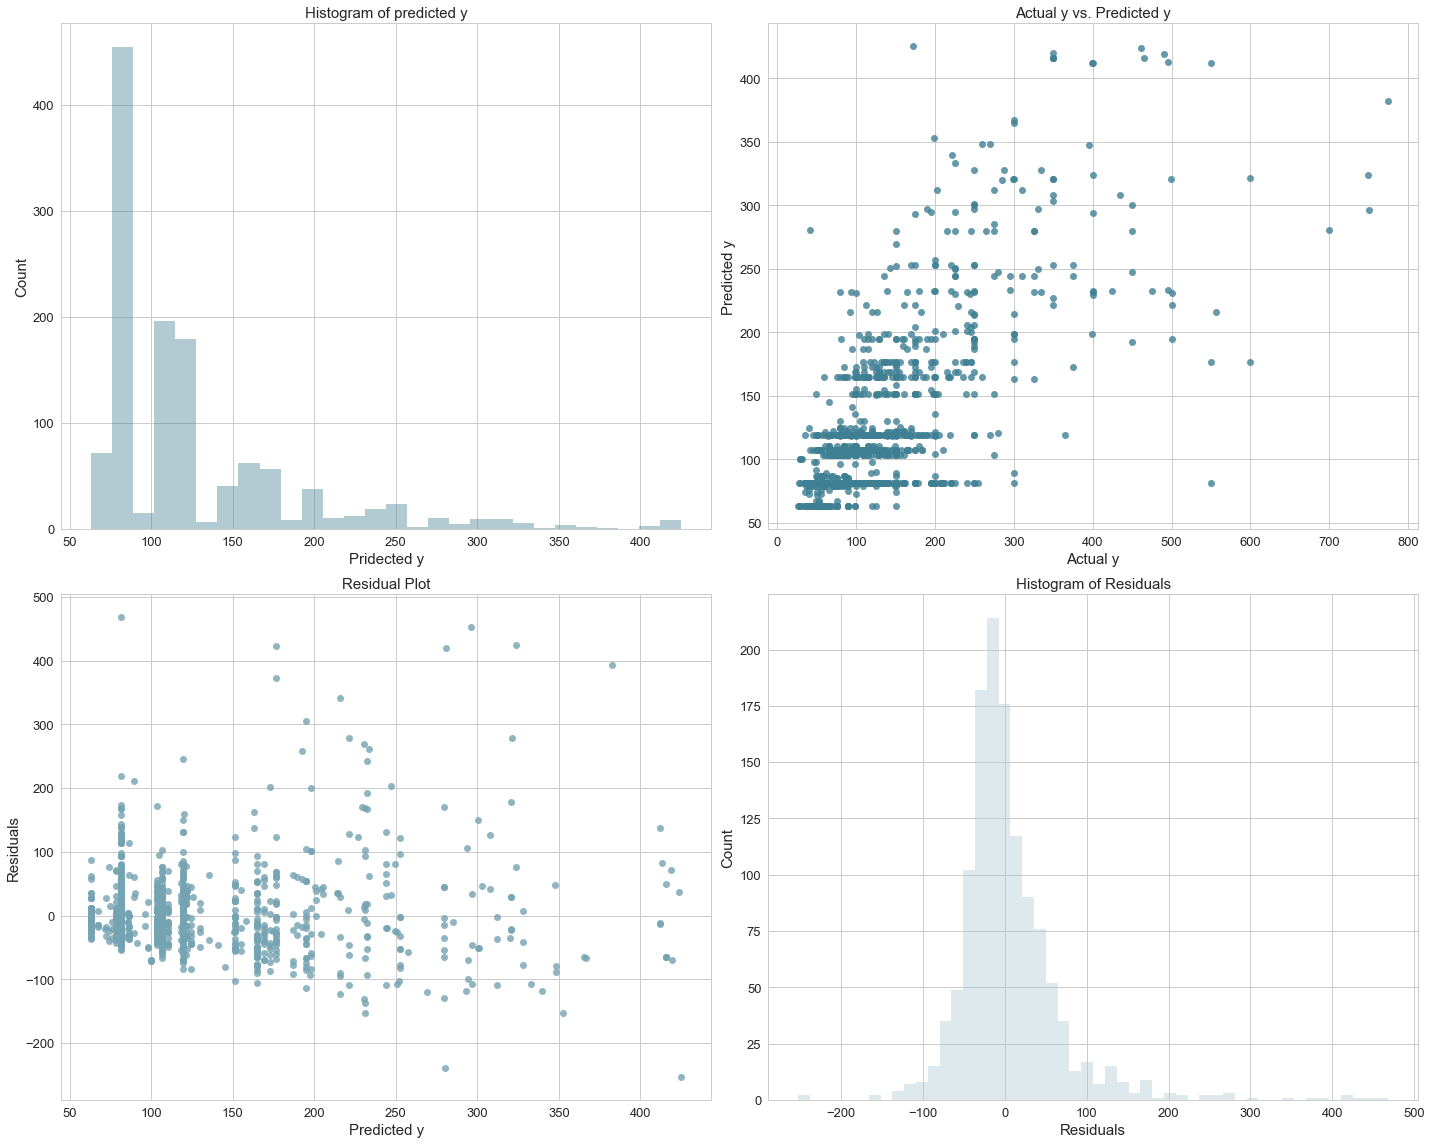

Model: Linear
    NOT taking log on y
    Best Params: {}
    MSE is:  4327.38782801
    RMSE is:  65.782884005


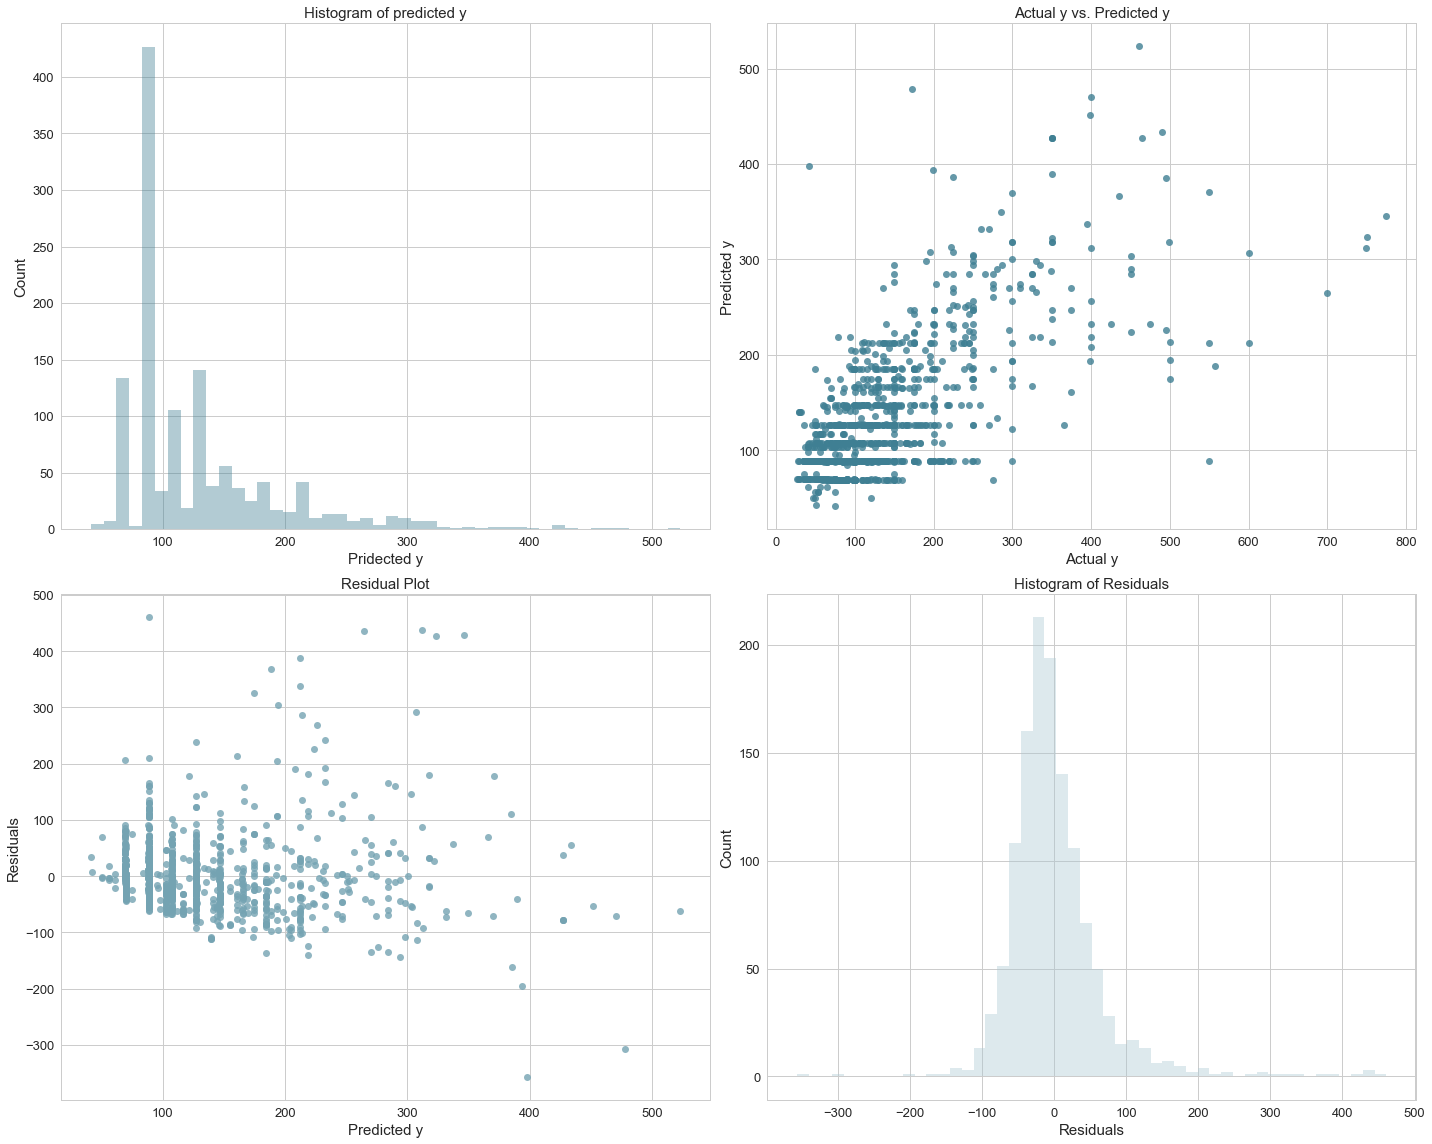

Model: Linear
    Taking log on y
    Best Params: {}
    MSE is:  6512.34037448
    RMSE is:  80.6990729468


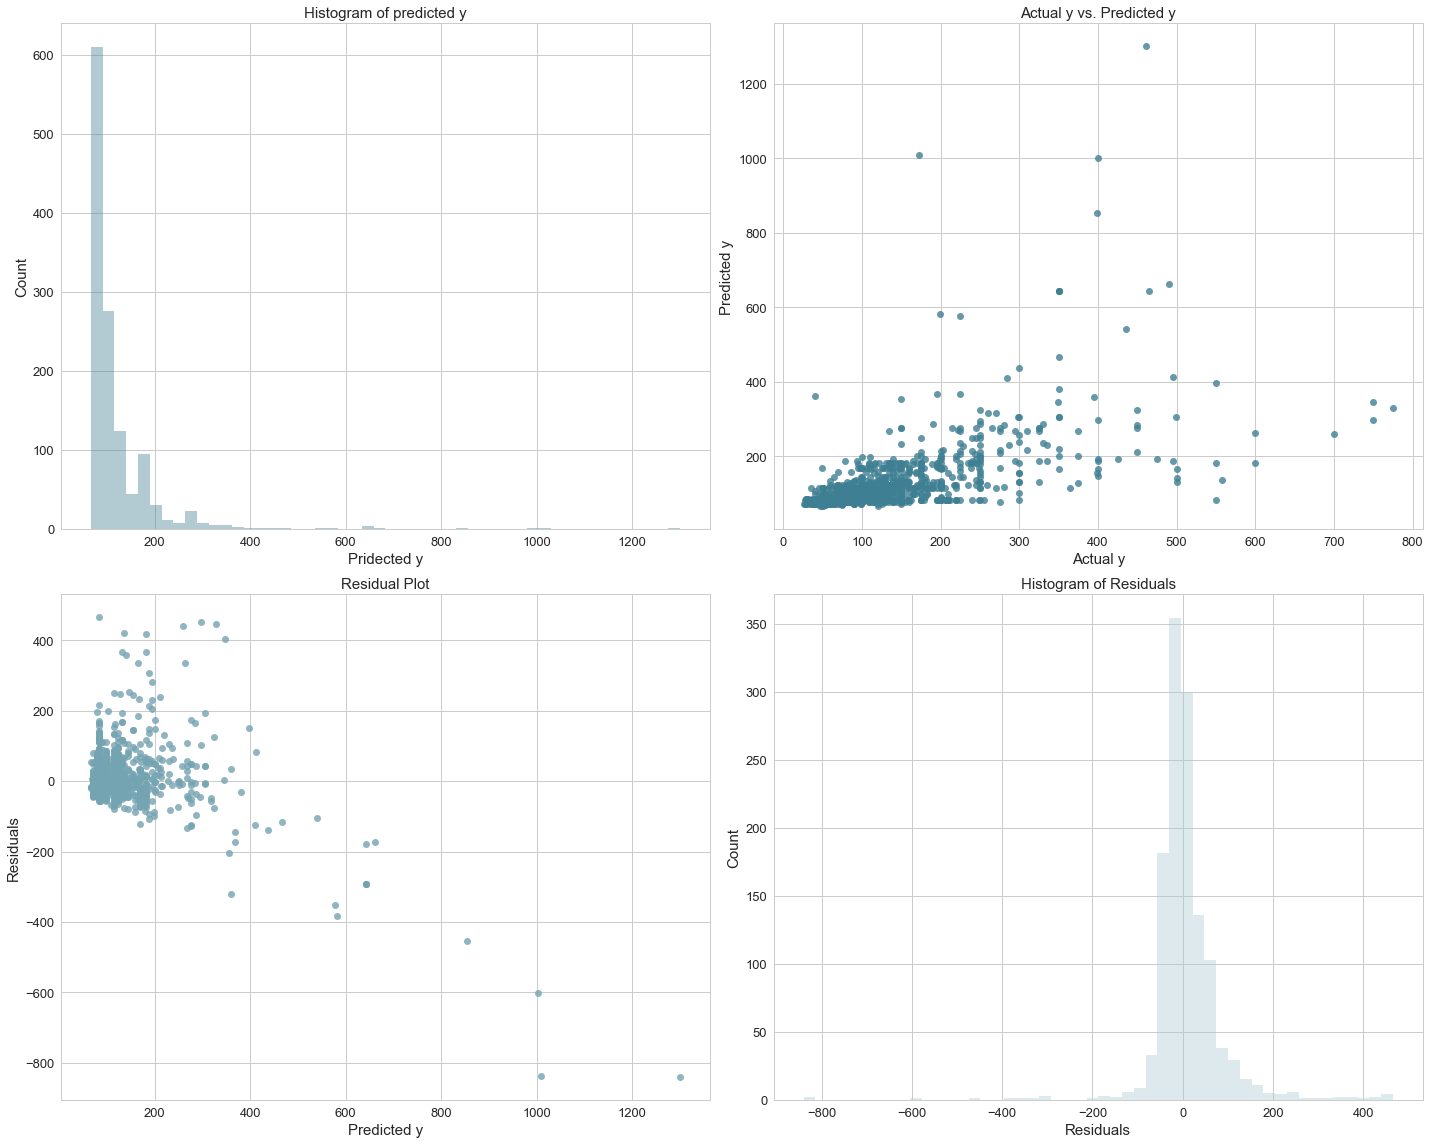

Model: Ridge
    NOT taking log on y
    Best Params: {'ridge__alpha': 50}
    MSE is:  4321.38490207
    RMSE is:  65.7372413634


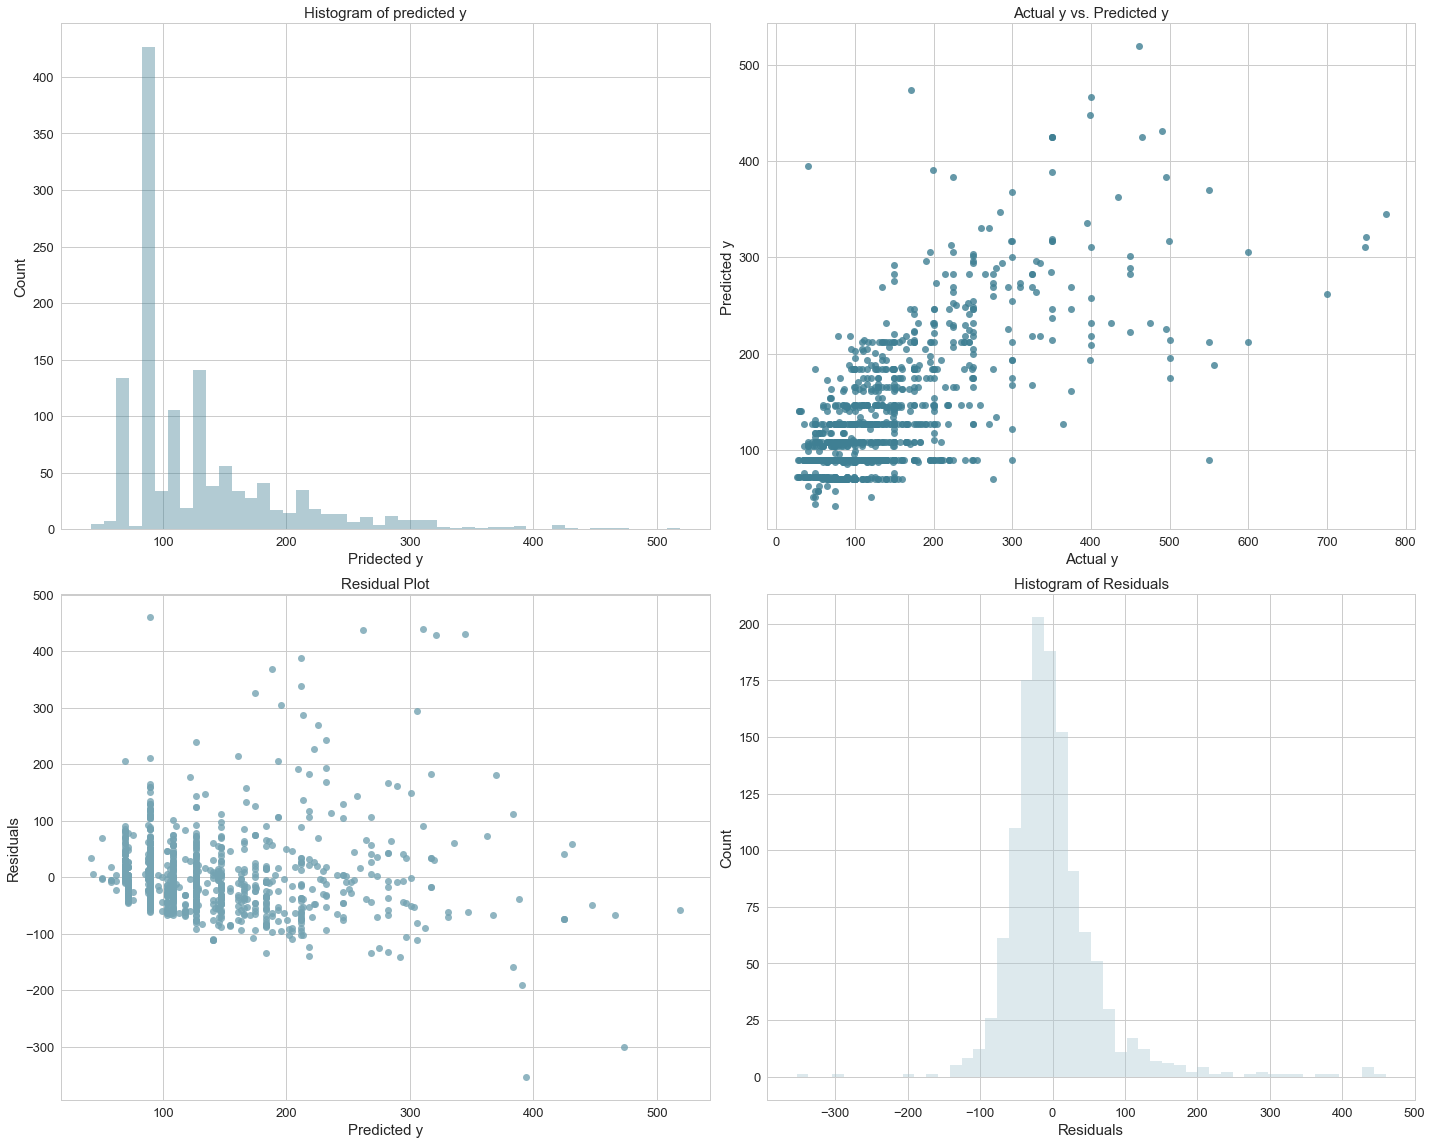

Model: Ridge
    Taking log on y
    Best Params: {'ridge__alpha': 10}
    MSE is:  6465.35382478
    RMSE is:  80.4074239407


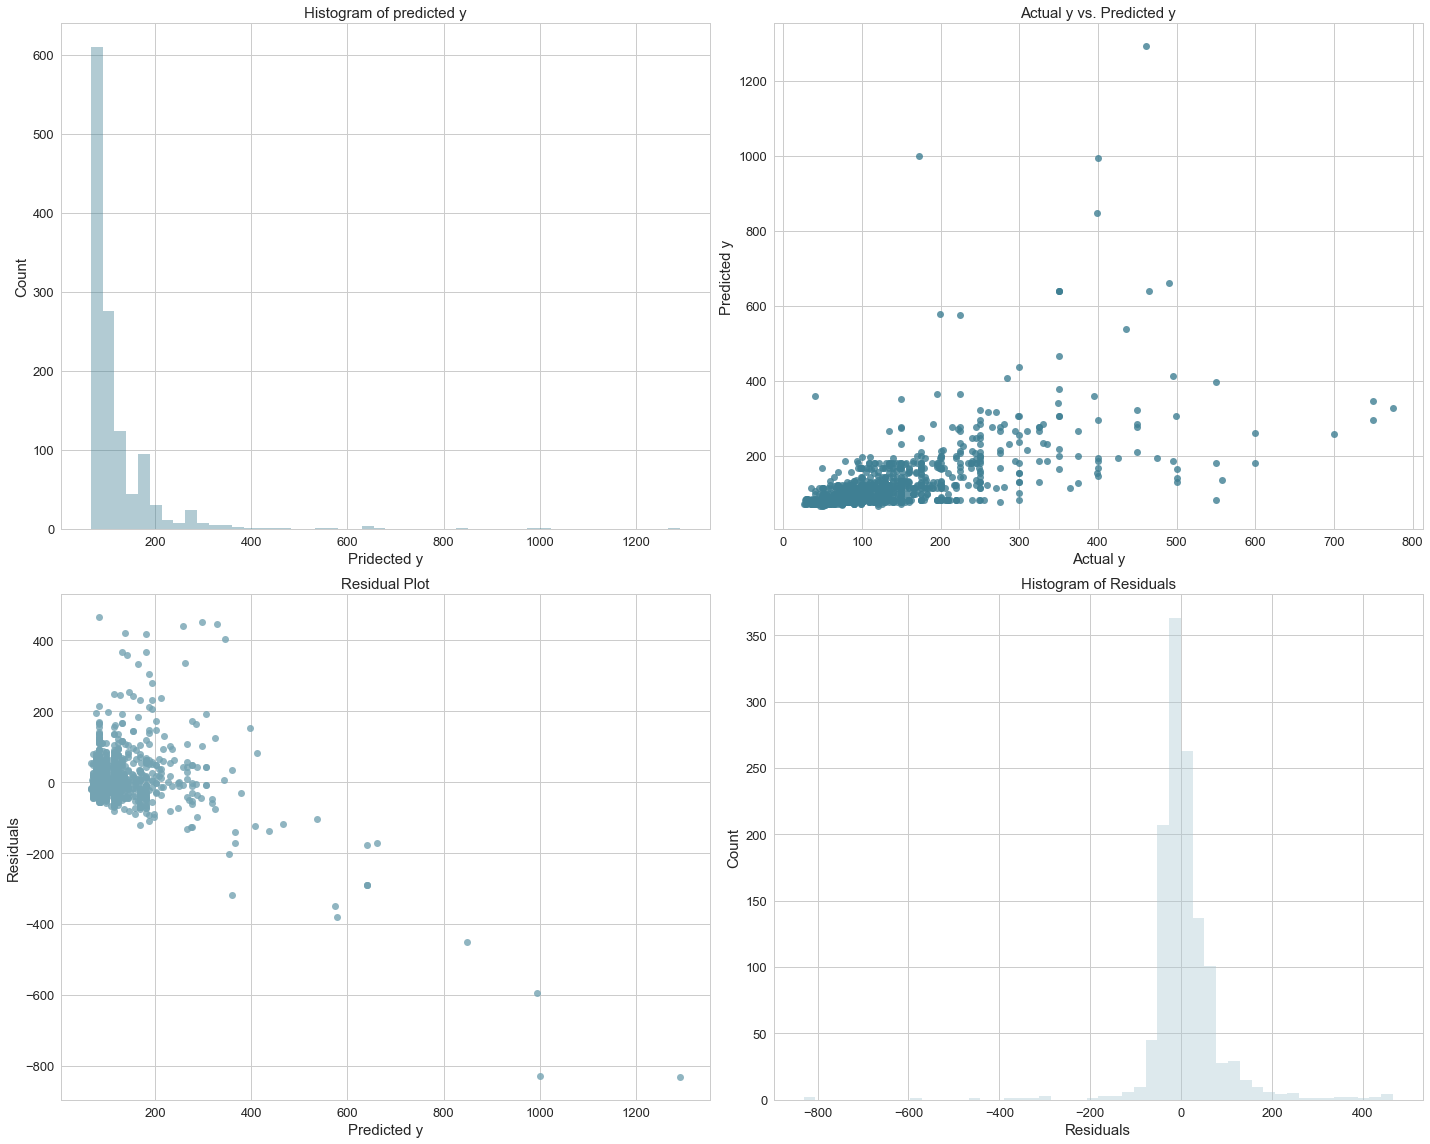

Model: Lasso
    NOT taking log on y
    Best Params: {'lasso__alpha': 0.0001}
    MSE is:  4327.39025804
    RMSE is:  65.782902475


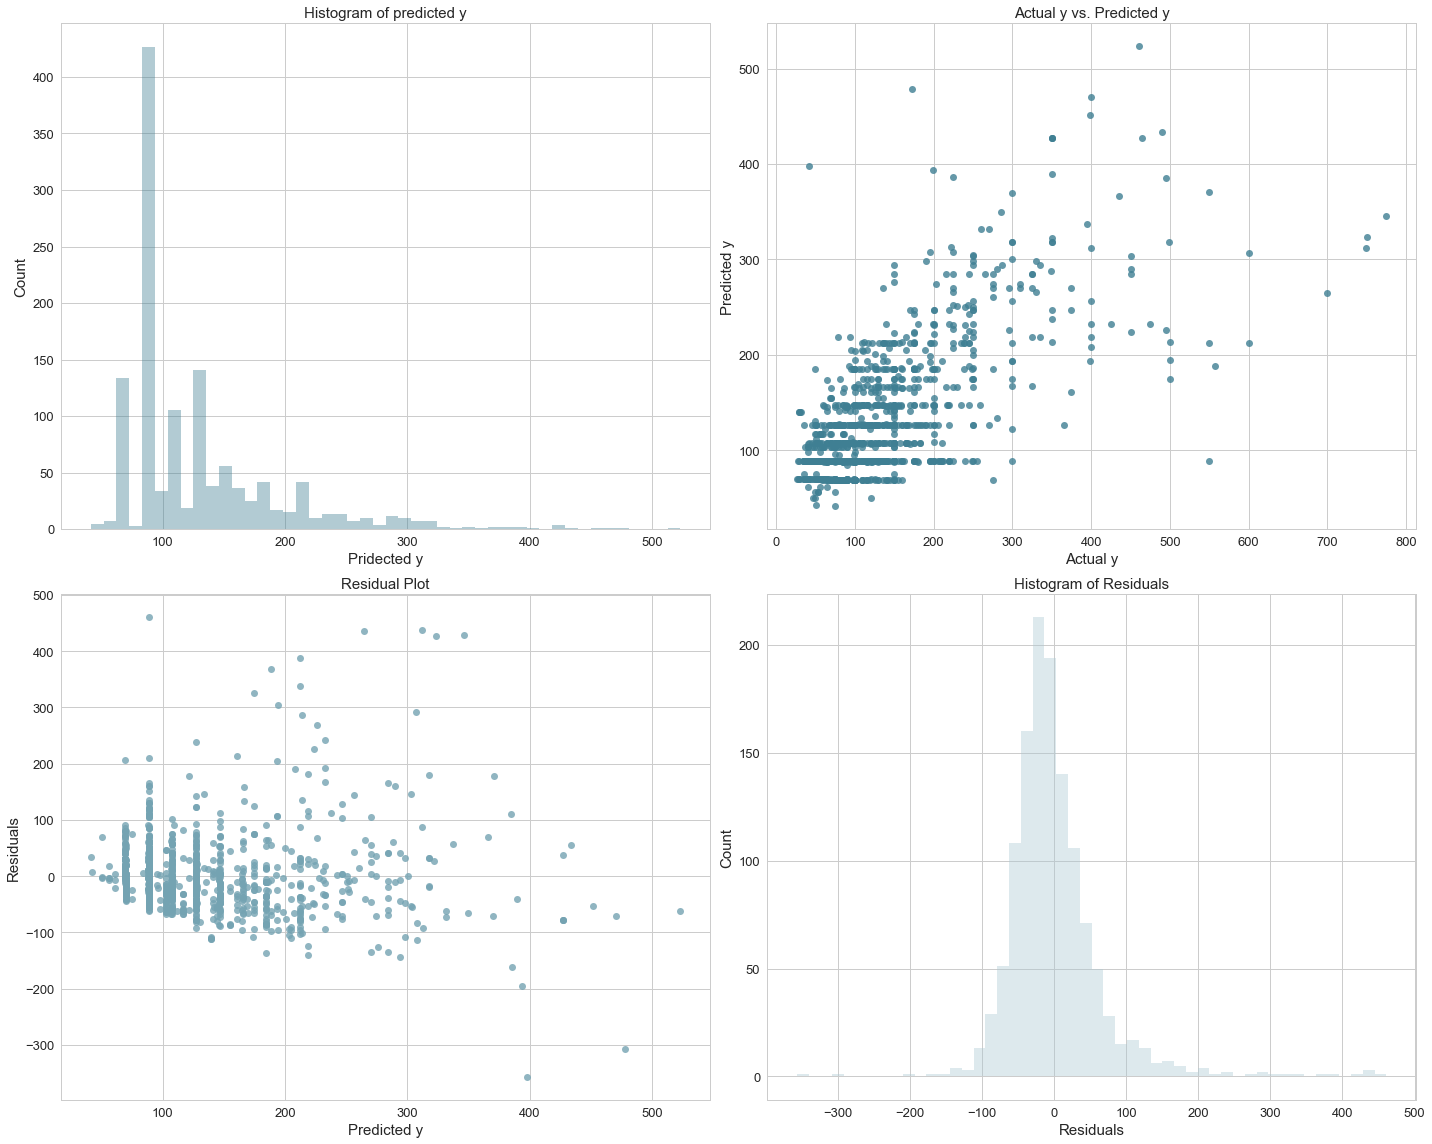

Model: Lasso
    Taking log on y
    Best Params: {'lasso__alpha': 0.0001}
    MSE is:  6510.48097874
    RMSE is:  80.6875515723


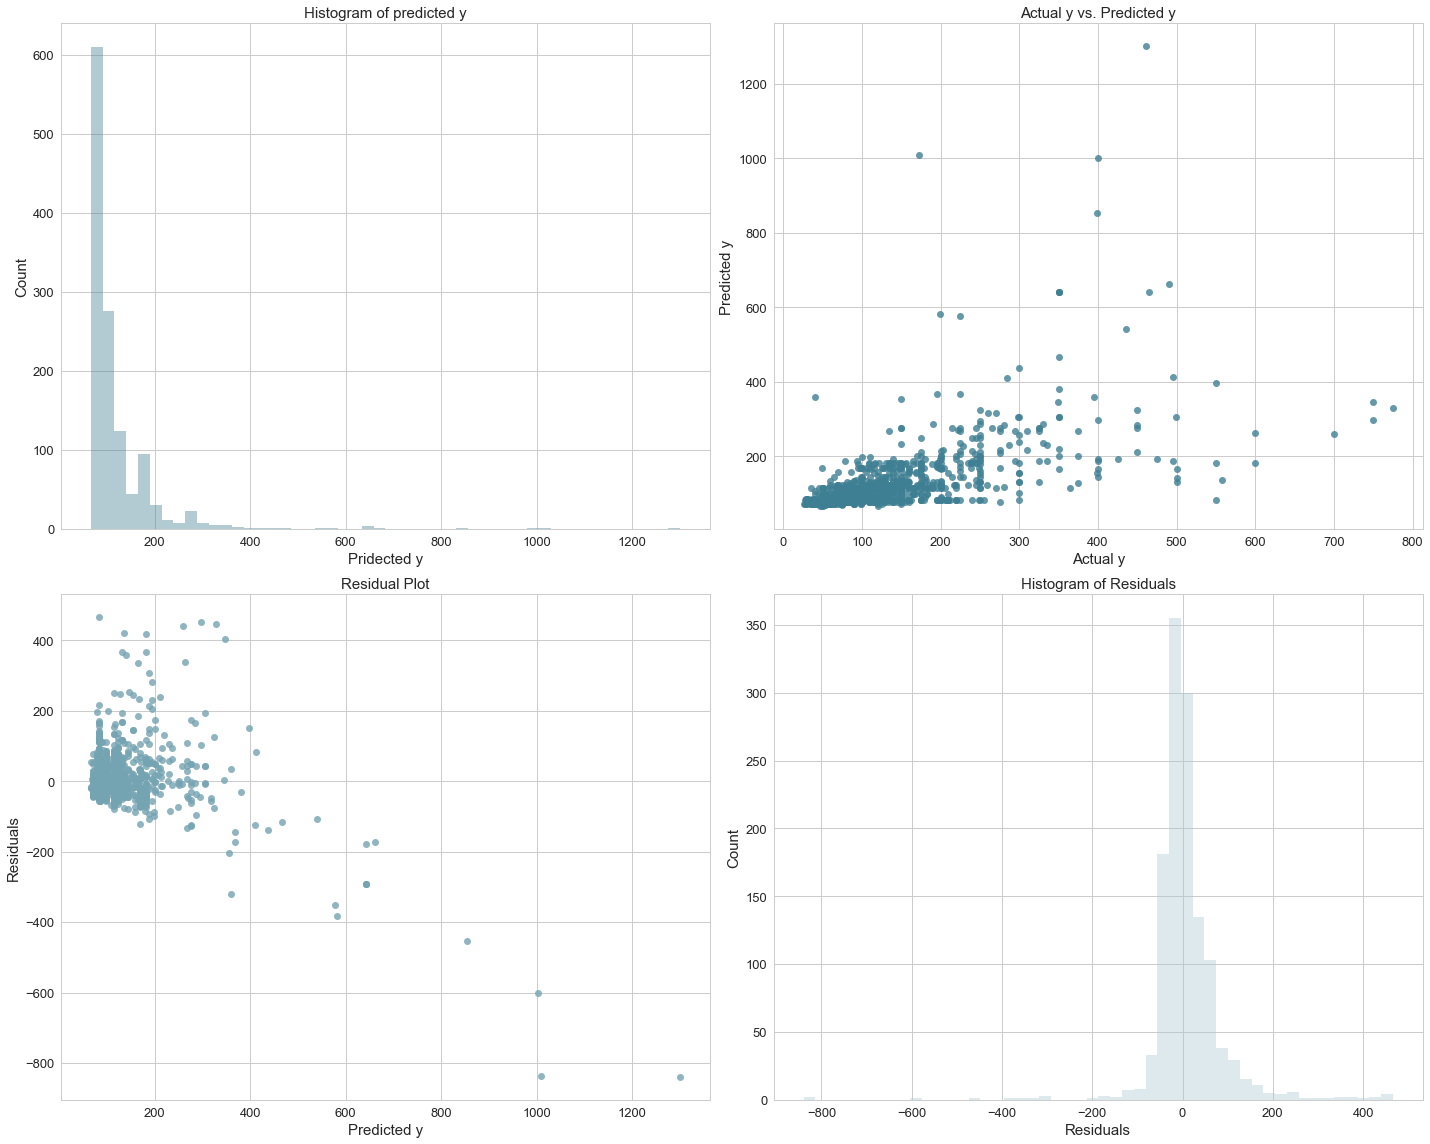

Model: RandomForest
    NOT taking log on y
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 30}
    MSE is:  4330.88713857
    RMSE is:  65.8094760545


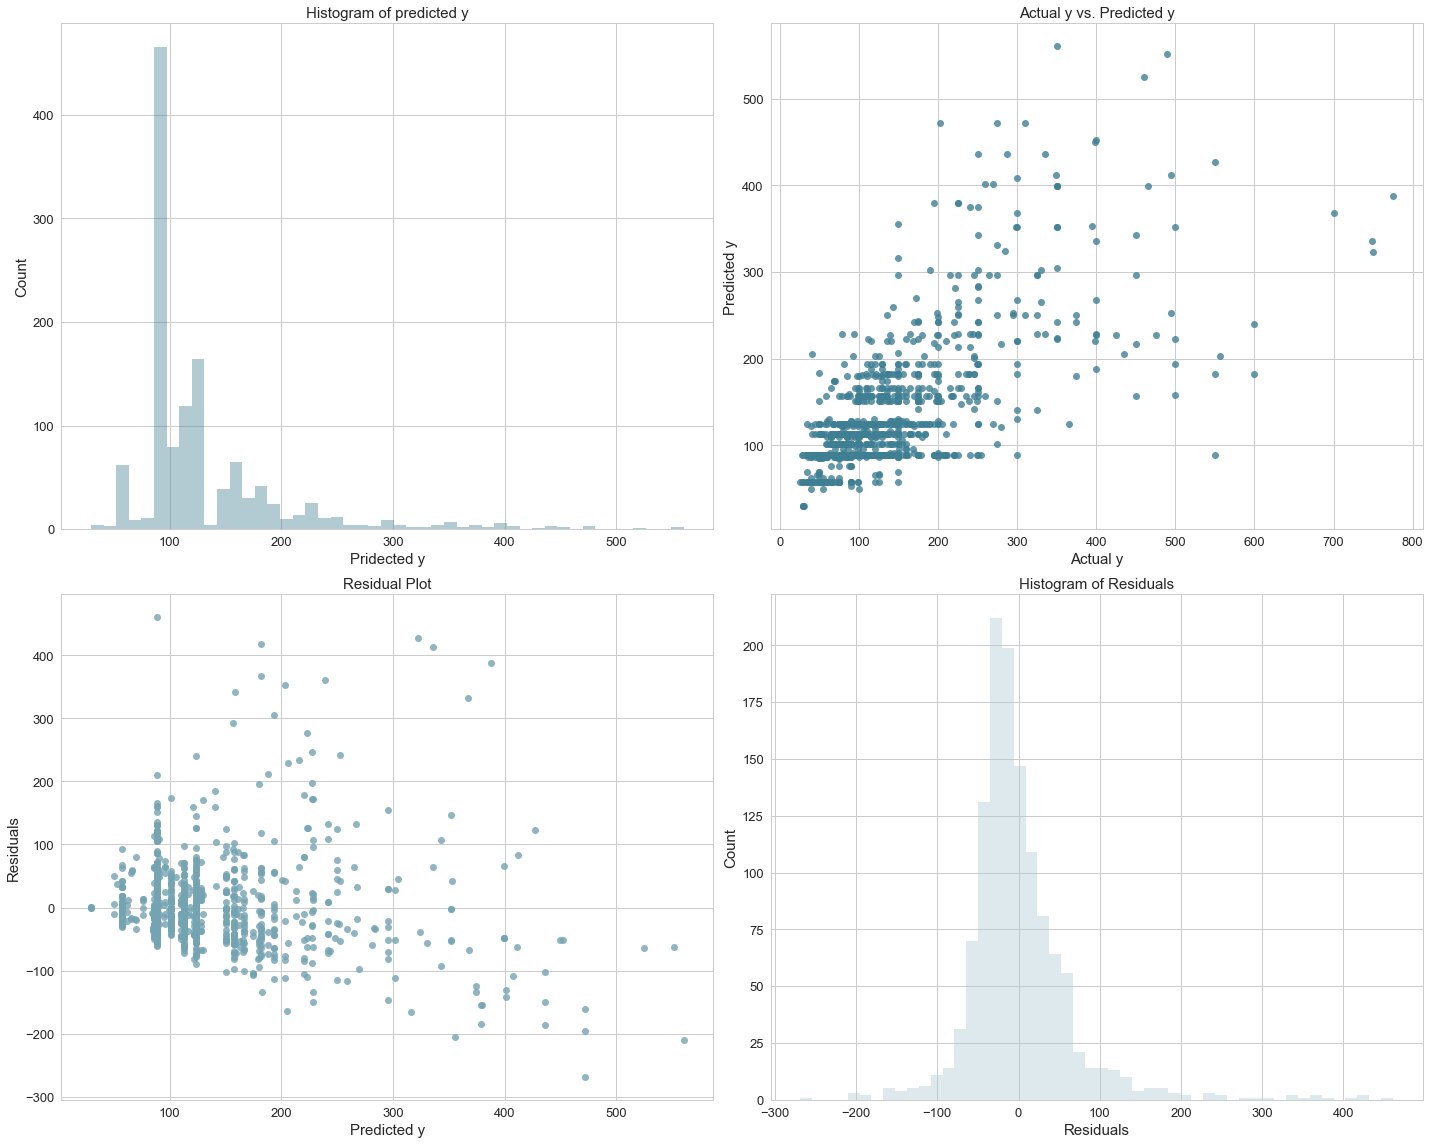

In [11]:
modelRmse = try_all_models(X, y)

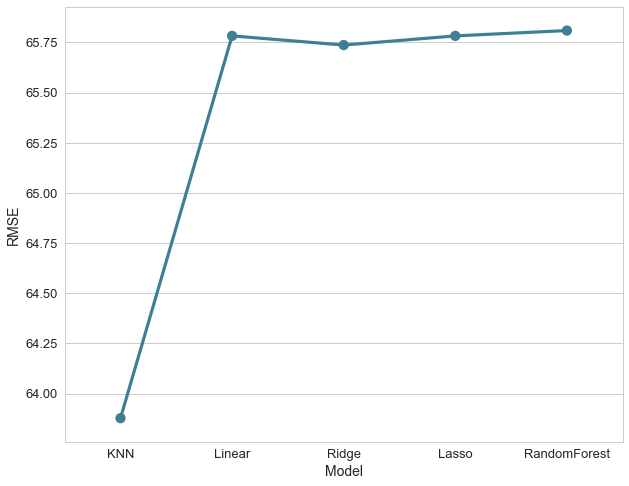

In [12]:
modelRmseDf = pd.DataFrame(list(modelRmse.items()))
modelRmseDf.columns = ['Model', 'RMSE']

fig, axes = get_sub_plots(1, 1)
sns.pointplot(x = "Model", y = "RMSE", data = modelRmseDf, ax = axes[0])
plt.show()

The initial results above showed that 
1. KNN has the best RMSE.
2. Although taking log on price did make it distribute more normally, RMSE isn't better. Let's plot influence plot using statsmodel to investiagate further:

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

m = ols('price ~ accommodates + bathrooms + bedrooms', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1182.
Date:                Sat, 18 Aug 2018   Prob (F-statistic):               0.00
Time:                        01:32:48   Log-Likelihood:                -21353.
No. Observations:                3818   AIC:                         4.271e+04
Df Residuals:                    3814   BIC:                         4.274e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.8480      2.590      2.258   

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


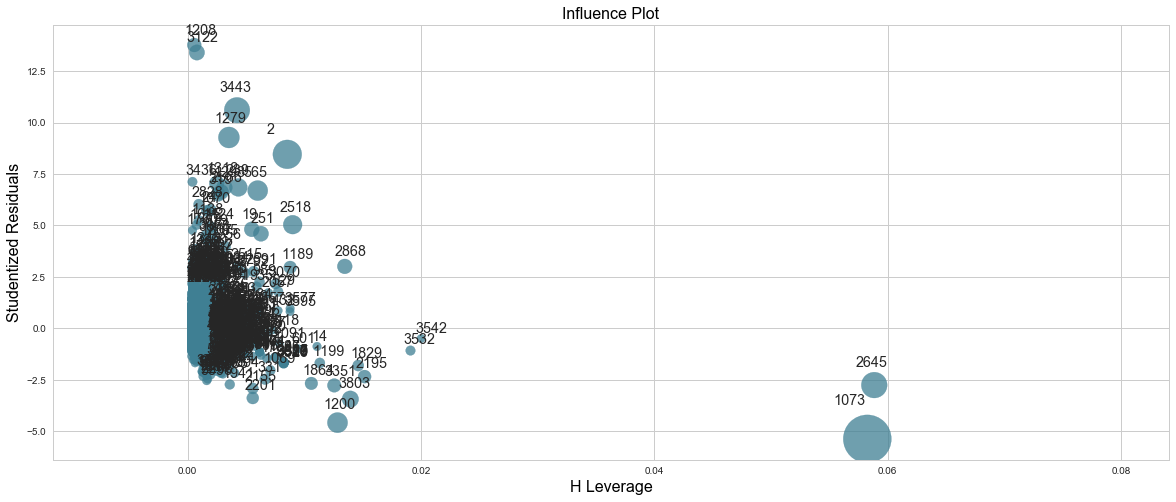

In [14]:
from statsmodels.graphics.regressionplots import influence_plot

fig, ax = plt.subplots(figsize = (20,8))
fig = sm.graphics.influence_plot(m, ax = ax, criterion = "cooks")

Remove high leverage points:

In [15]:
df = df.drop(df.index[[1073, 2645, 3532, 3542, 1829, 2195]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3812 entries, 0 to 3817
Data columns (total 18 columns):
price                              3812 non-null float64
neighbourhood_cleansed             3812 non-null int64
zipcode                            3812 non-null int64
property_type                      3812 non-null int64
room_type                          3812 non-null int64
accommodates                       3812 non-null int64
bathrooms                          3812 non-null float64
bedrooms                           3812 non-null float64
beds                               3812 non-null float64
bed_type                           3812 non-null int64
guests_included                    3812 non-null int64
cancellation_policy                3812 non-null int64
cleaning_fee                       3812 non-null float64
latitude_longitude_bin             3812 non-null int64
neighbourhood_cleansed_reverted    3812 non-null object
shapes                             3812 non-null object
a

In [16]:
m = ols('price ~ accommodates + bathrooms + bedrooms', df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     1211.
Date:                Sat, 18 Aug 2018   Prob (F-statistic):               0.00
Time:                        01:32:55   Log-Likelihood:                -21297.
No. Observations:                3812   AIC:                         4.260e+04
Df Residuals:                    3808   BIC:                         4.263e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4742      2.655      0.555   

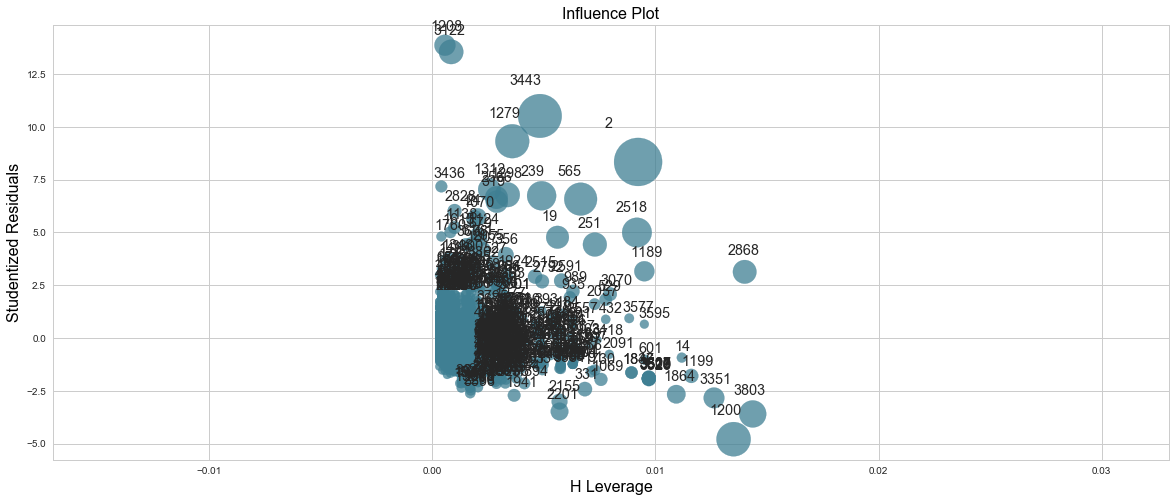

In [17]:
fig, ax = plt.subplots(figsize = (20,8))
fig = sm.graphics.influence_plot(m, ax = ax, criterion = "cooks")

High leverage points are removed. Let's train the model again:

In [18]:
X, y = get_X_y(df, ['accommodates', 'bathrooms', 'bedrooms'], 'price')

Model: KNN
    NOT taking log on y
    Best Params: {'knn__n_neighbors': 47}
    MSE is:  4327.04118647
    RMSE is:  65.7802492126


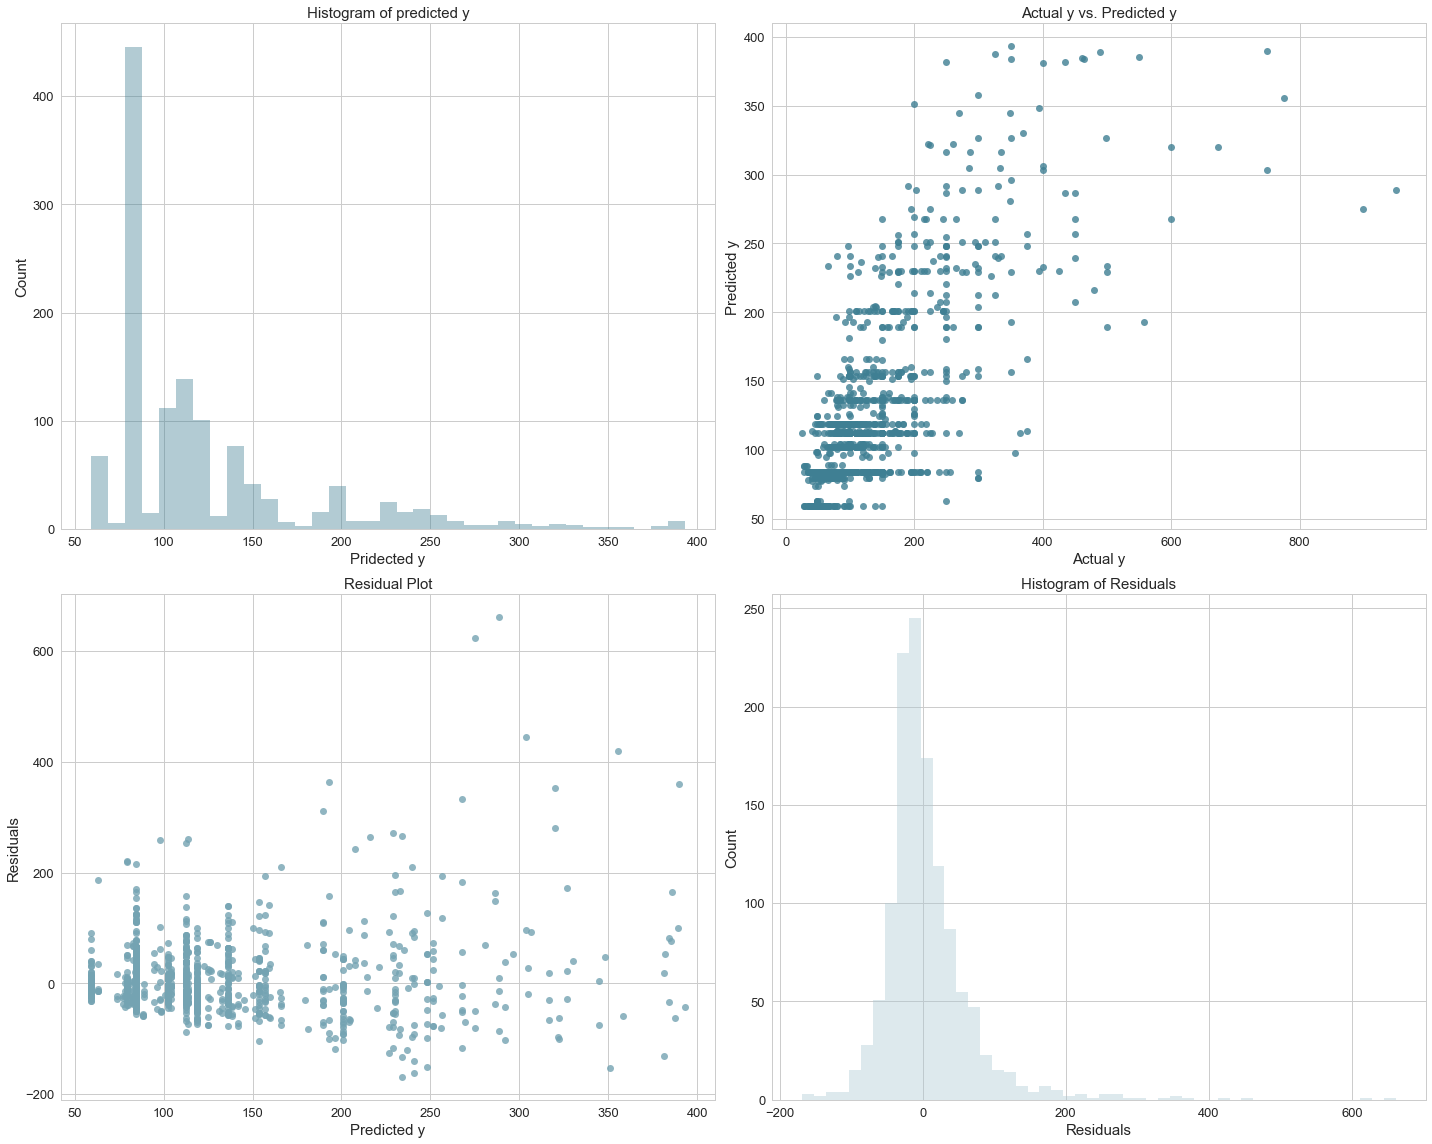

Model: Linear
    NOT taking log on y
    Best Params: {}
    MSE is:  4416.57460282
    RMSE is:  66.4573141409


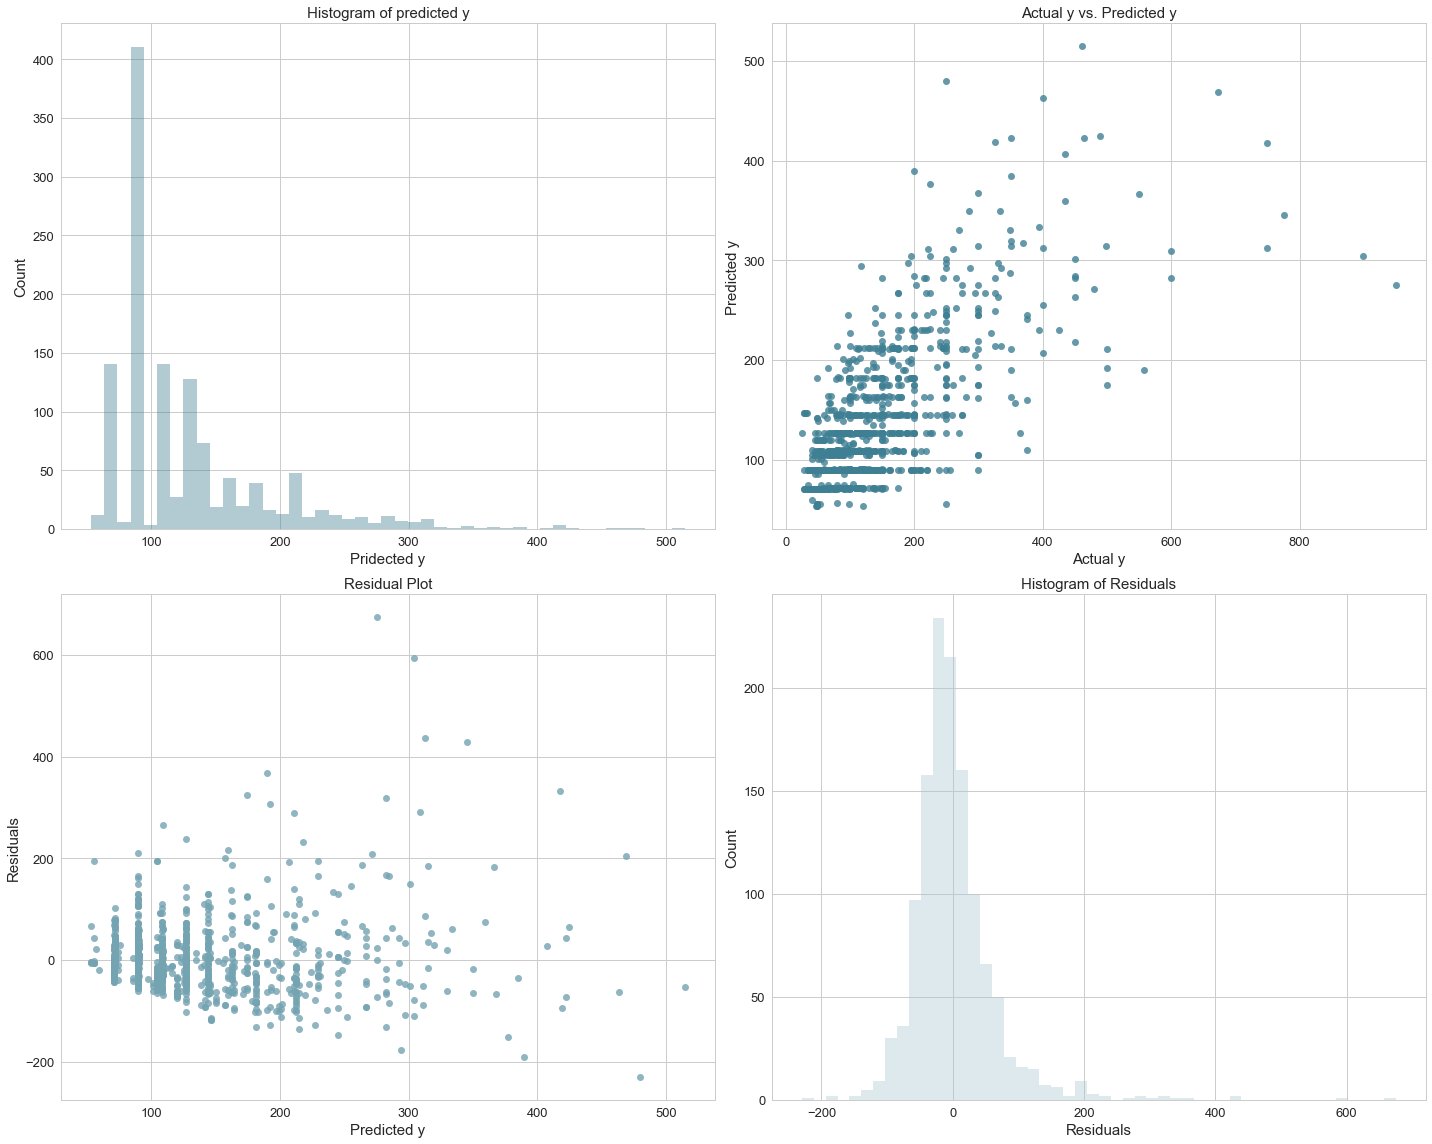

Model: Linear
    Taking log on y
    Best Params: {}
    MSE is:  6823.03714871
    RMSE is:  82.6016776386


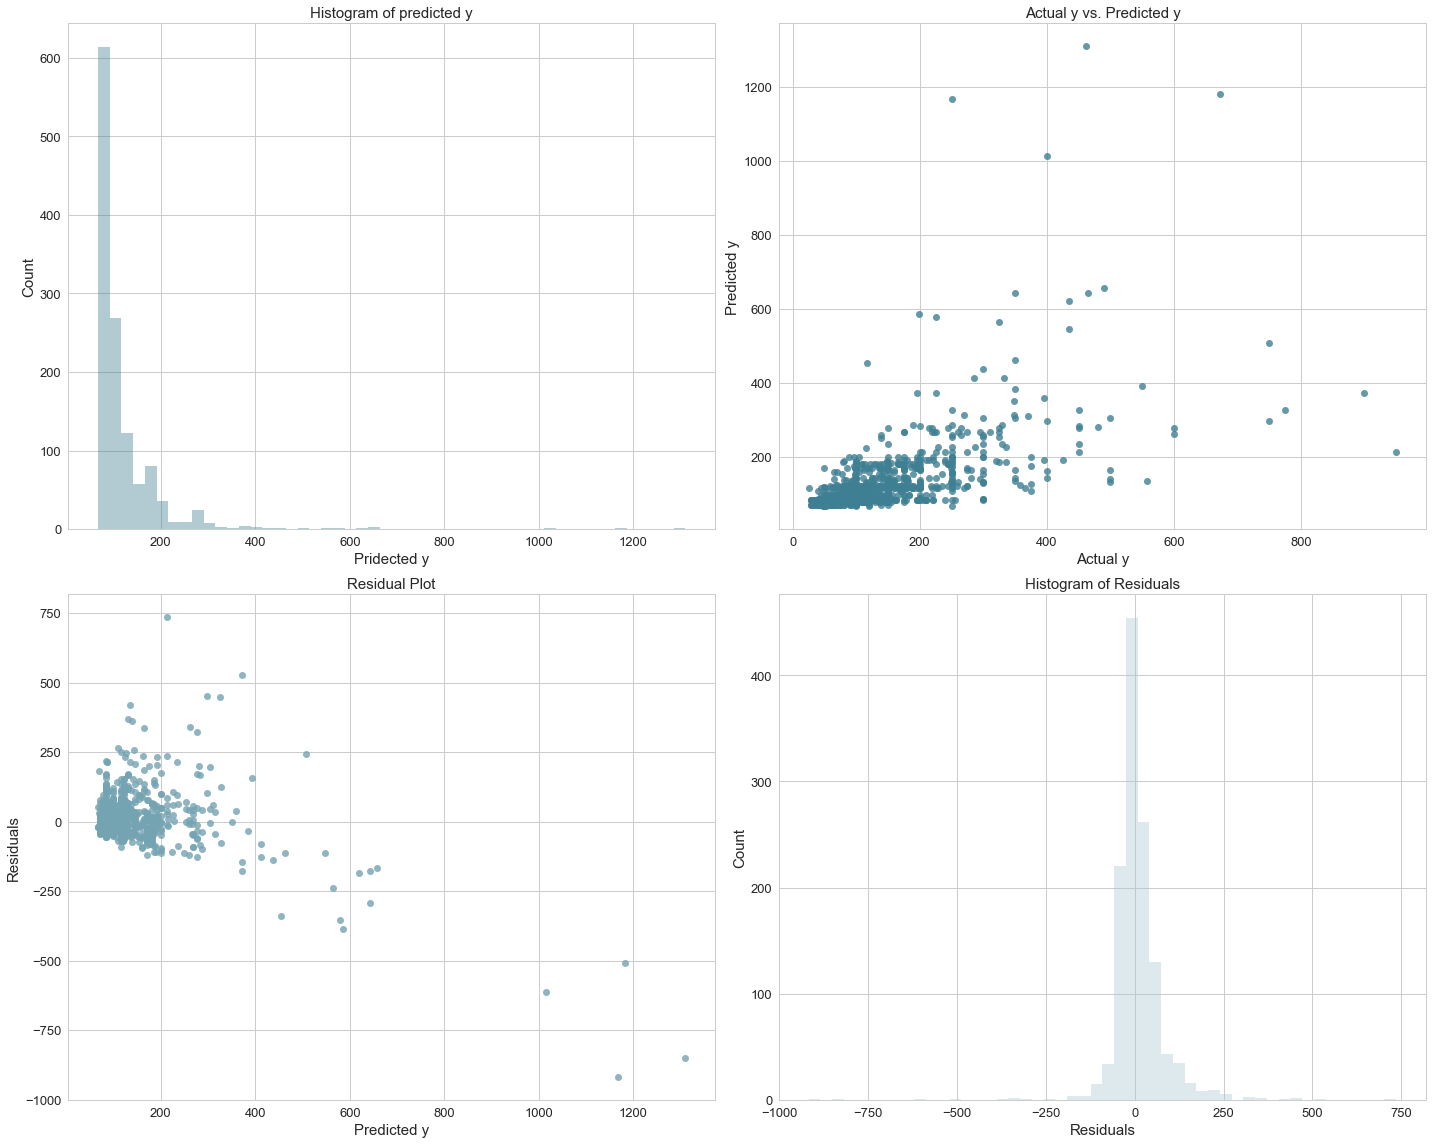

Model: Ridge
    NOT taking log on y
    Best Params: {'ridge__alpha': 50}
    MSE is:  4416.79397499
    RMSE is:  66.4589645946


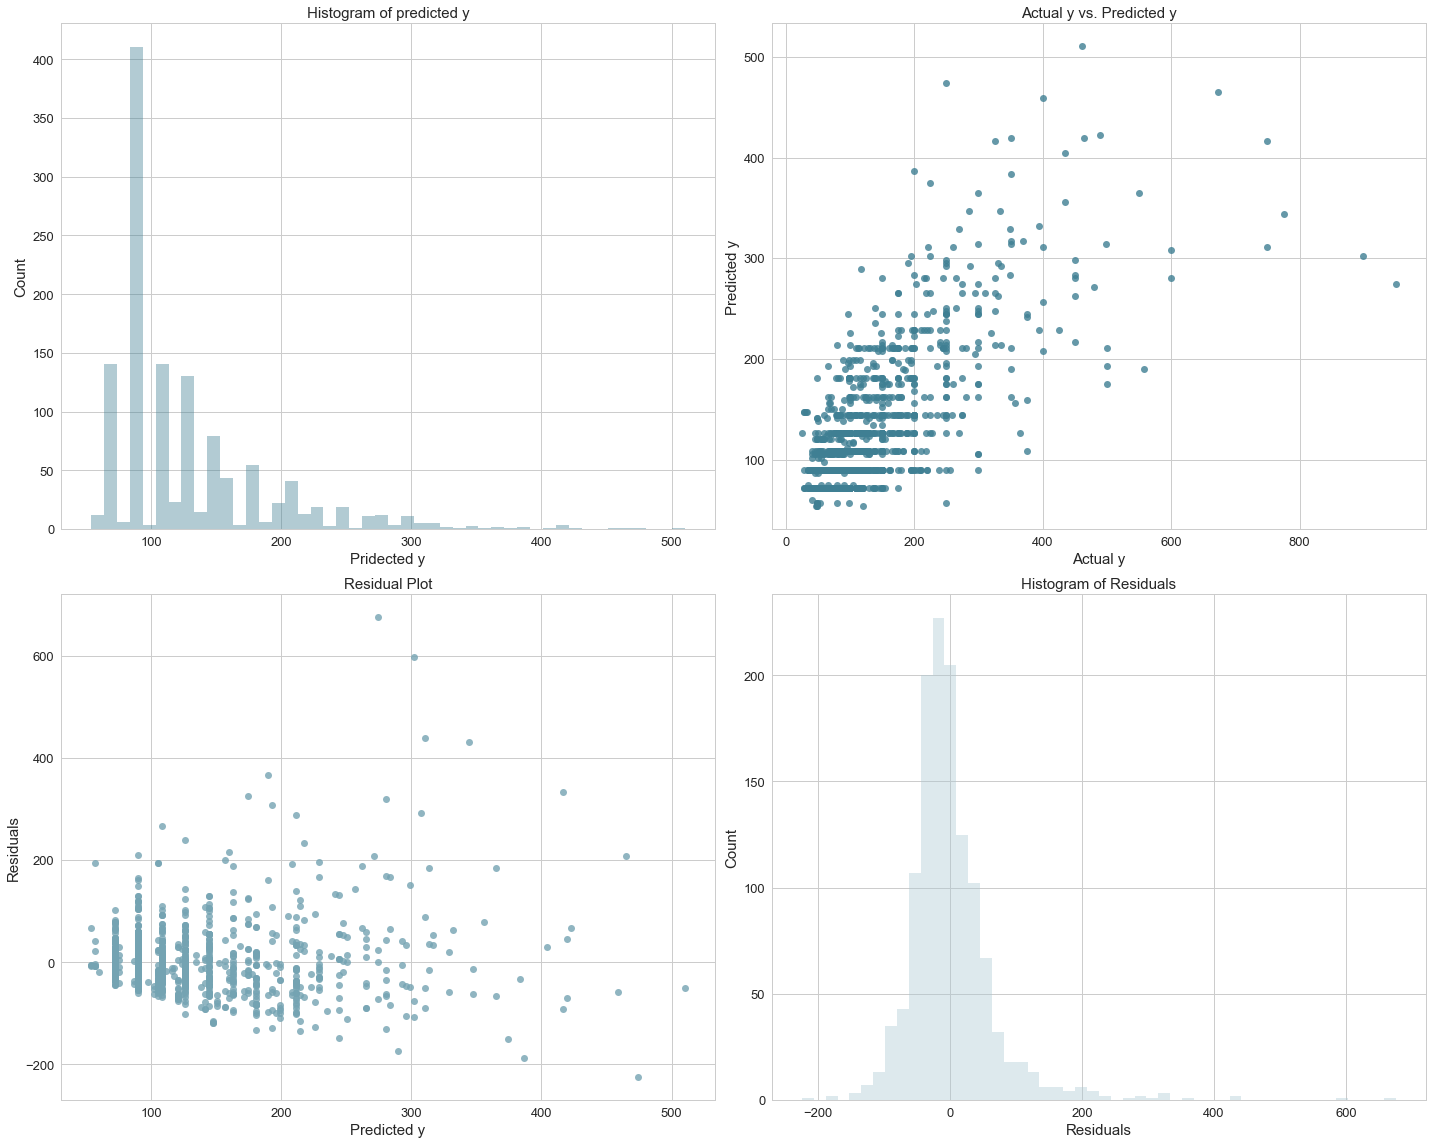

Model: Ridge
    Taking log on y
    Best Params: {'ridge__alpha': 10}
    MSE is:  6761.91558373
    RMSE is:  82.2308675847


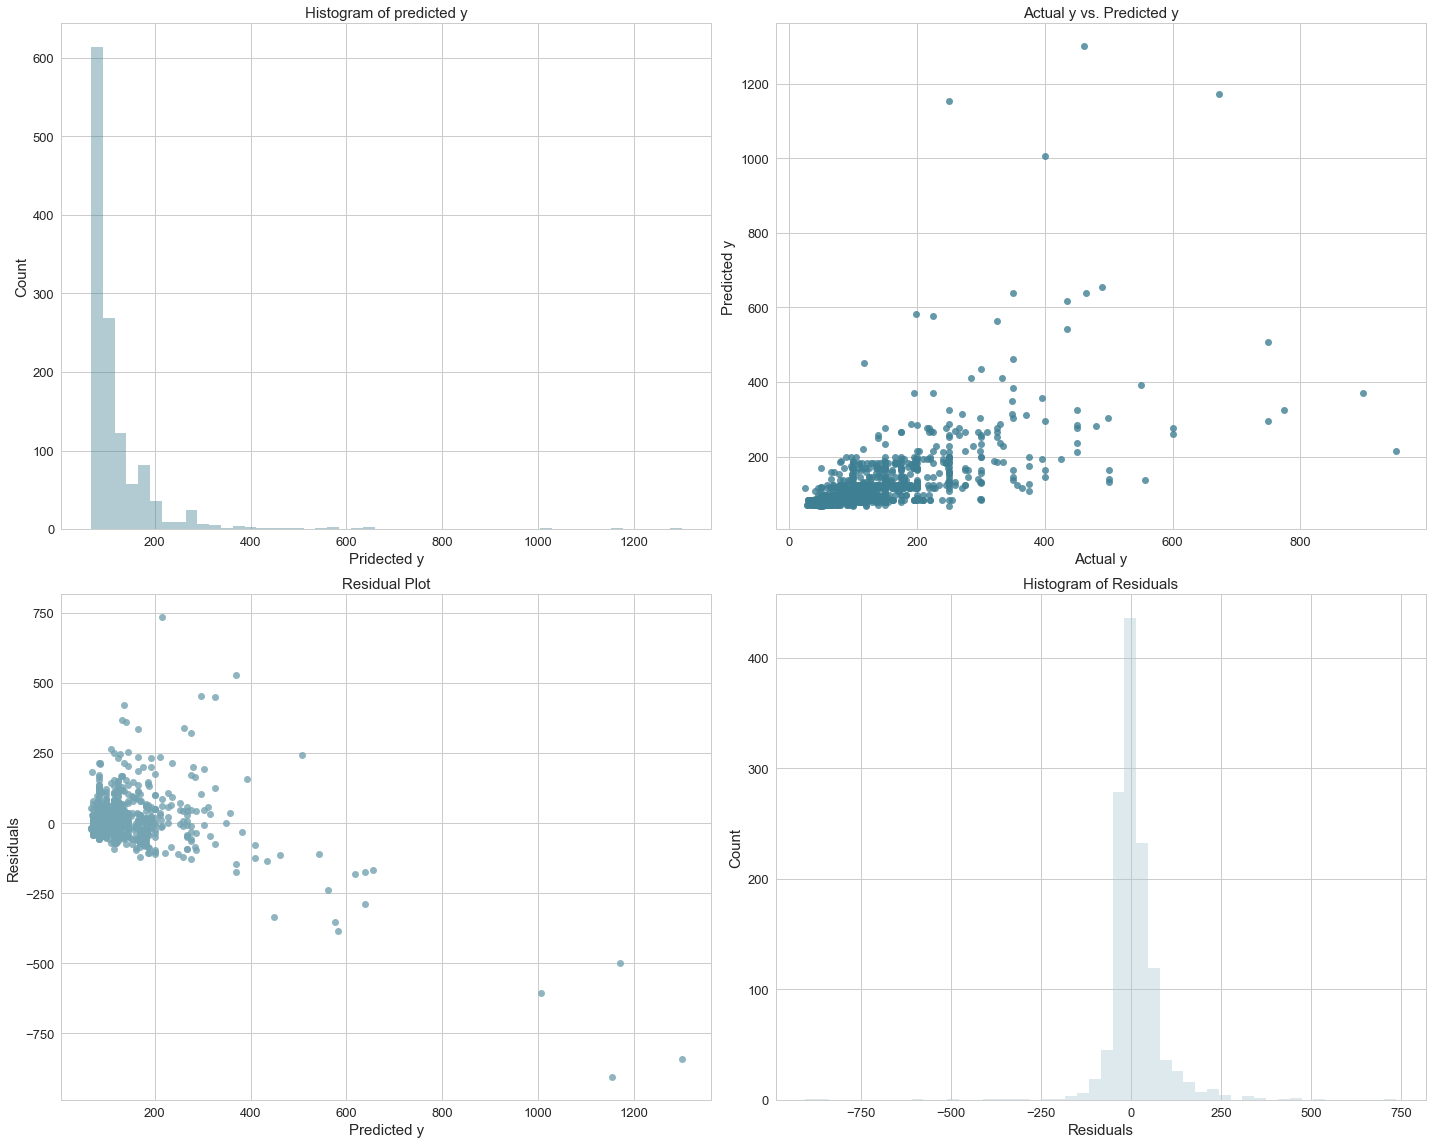

Model: Lasso
    NOT taking log on y
    Best Params: {'lasso__alpha': 0.01}
    MSE is:  4416.80841503
    RMSE is:  66.4590732333


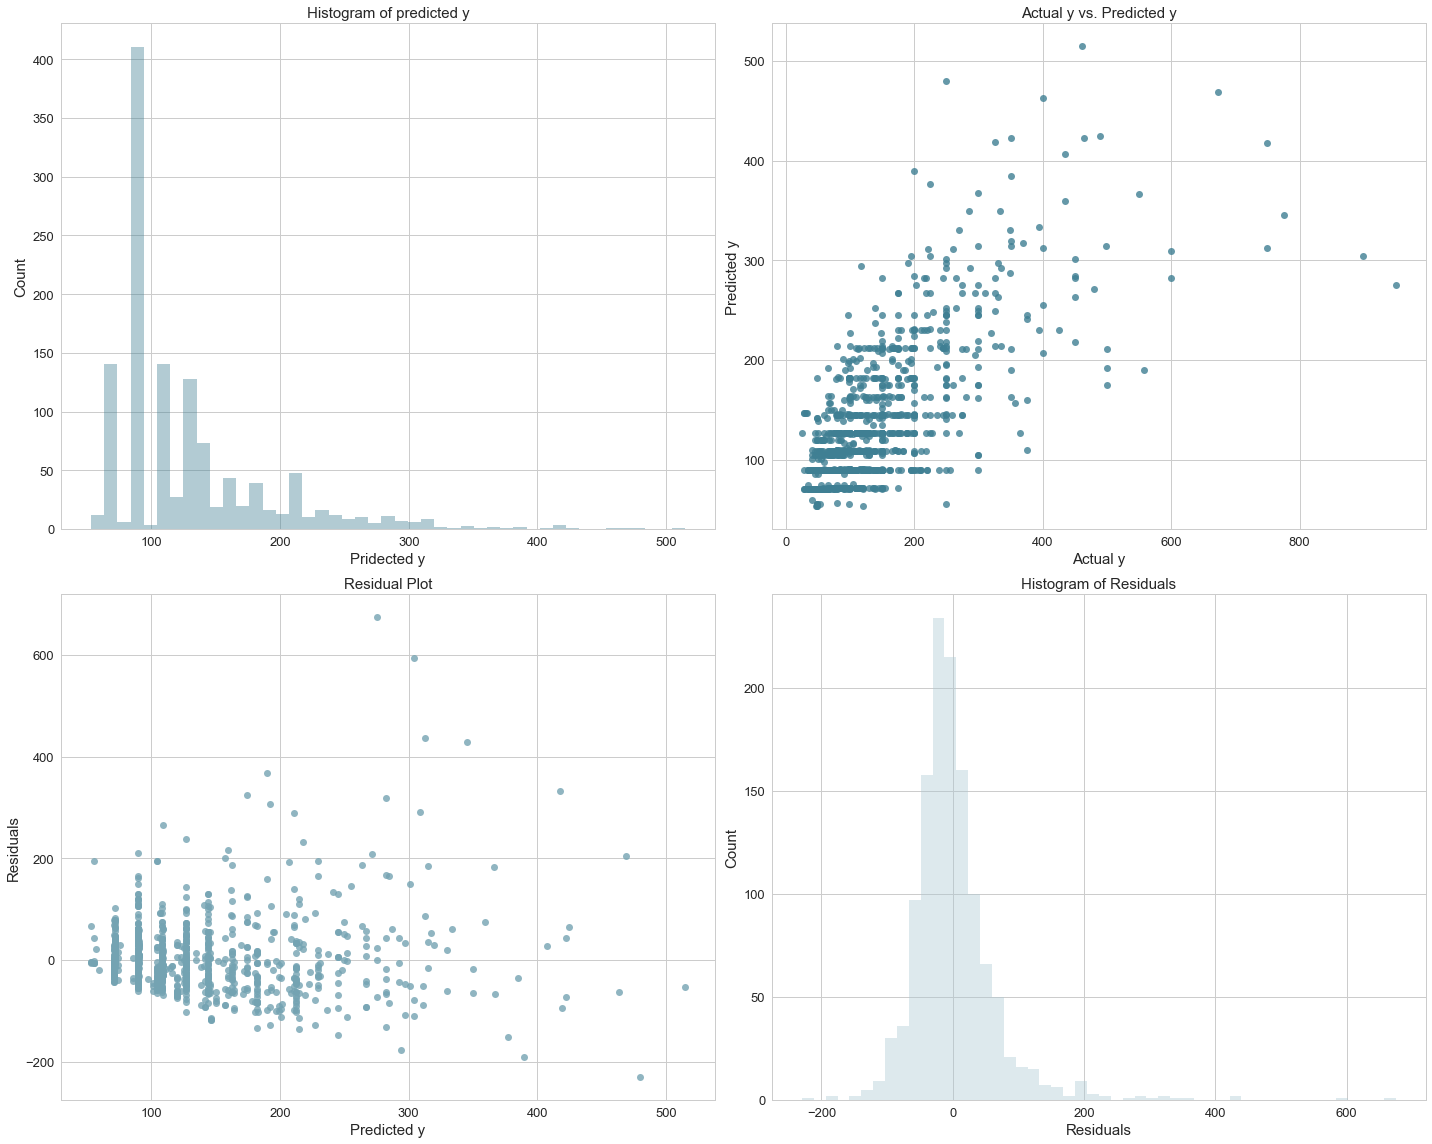

Model: Lasso
    Taking log on y
    Best Params: {'lasso__alpha': 0.0001}
    MSE is:  6822.61172243
    RMSE is:  82.5991024311


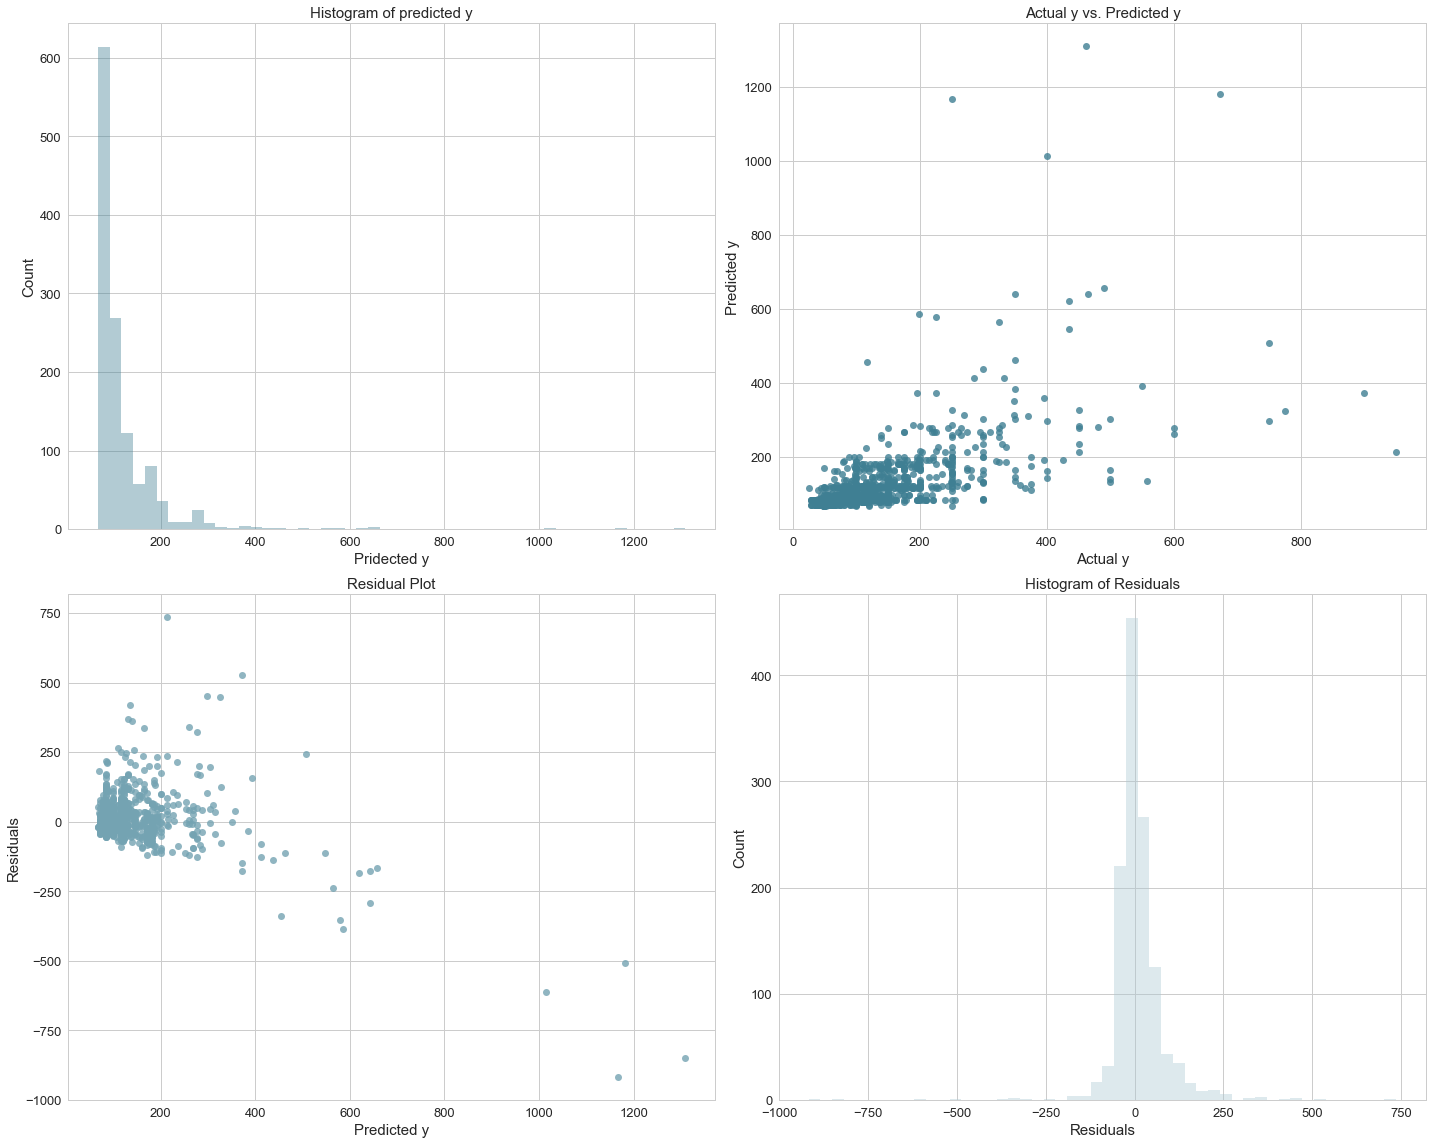

Model: RandomForest
    NOT taking log on y
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 80}
    MSE is:  4376.31034807
    RMSE is:  66.1536873354


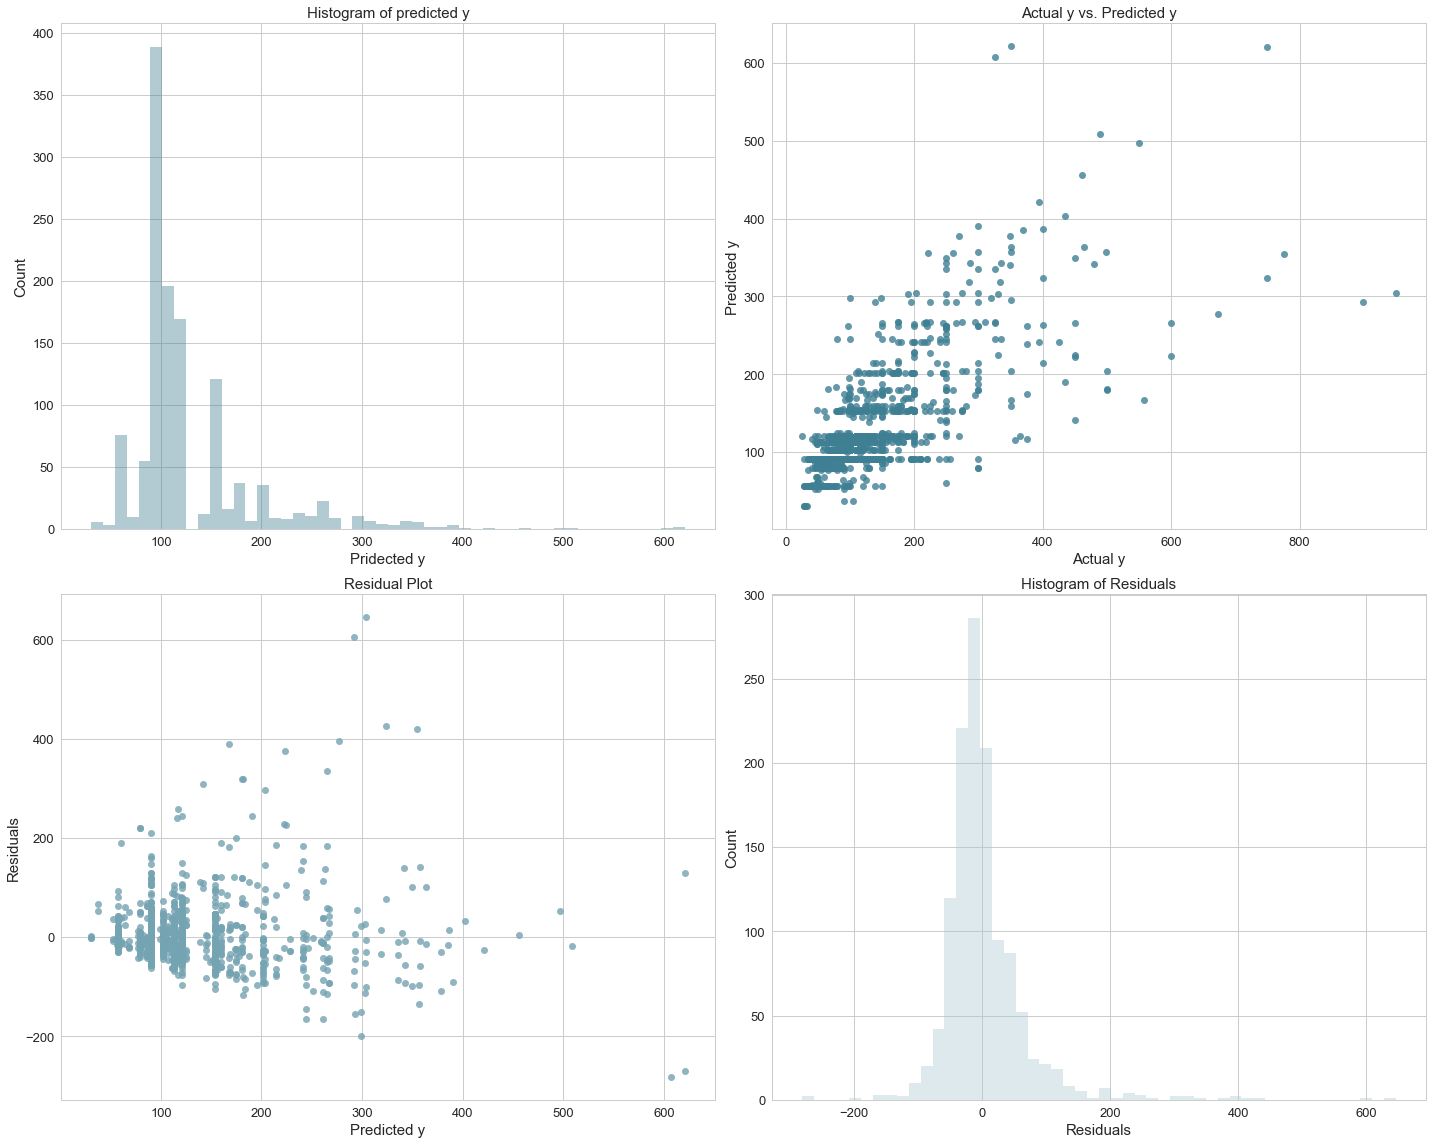

{'KNN': 65.780249212620561,
 'Lasso': 66.459073233328155,
 'Linear': 66.457314140883085,
 'RandomForest': 66.153687335371572,
 'Ridge': 66.458964594598626}

In [19]:
try_all_models(X, y)

Still RSME isn't better on linear models when taking log on price.

**TODO**:
It looks like there are less datapoints with price above about 300 and looks like they have a different linear relationship. For this piecewise linear regression is sometimes used.

Let's get back to check which model is beteer. Based on the above RMSEs, **KNN** & **random forest** have the best RMSE.

Let's take a closer look at them and check the outliers:

#### K-Nearest Neighbors

In [20]:
def KNN(X, y, df):
    steps = [('scaler', StandardScaler())]
    steps += [('knn', KNeighborsRegressor())]
    
    param_grid = {'knn__n_neighbors': np.arange(1, 50)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model: KNN')
    print('    Best Params:', cv.best_params_)

    y_pred_knn = cv.predict(X_test)
    score_and_plot(y_test, y_pred_knn)

    df['price_pred_knn'] = cv.predict(X)
    
    return (y_test, y_pred_knn)

Model: KNN
    Best Params: {'knn__n_neighbors': 47}
    MSE is:  4327.04118647
    RMSE is:  65.7802492126


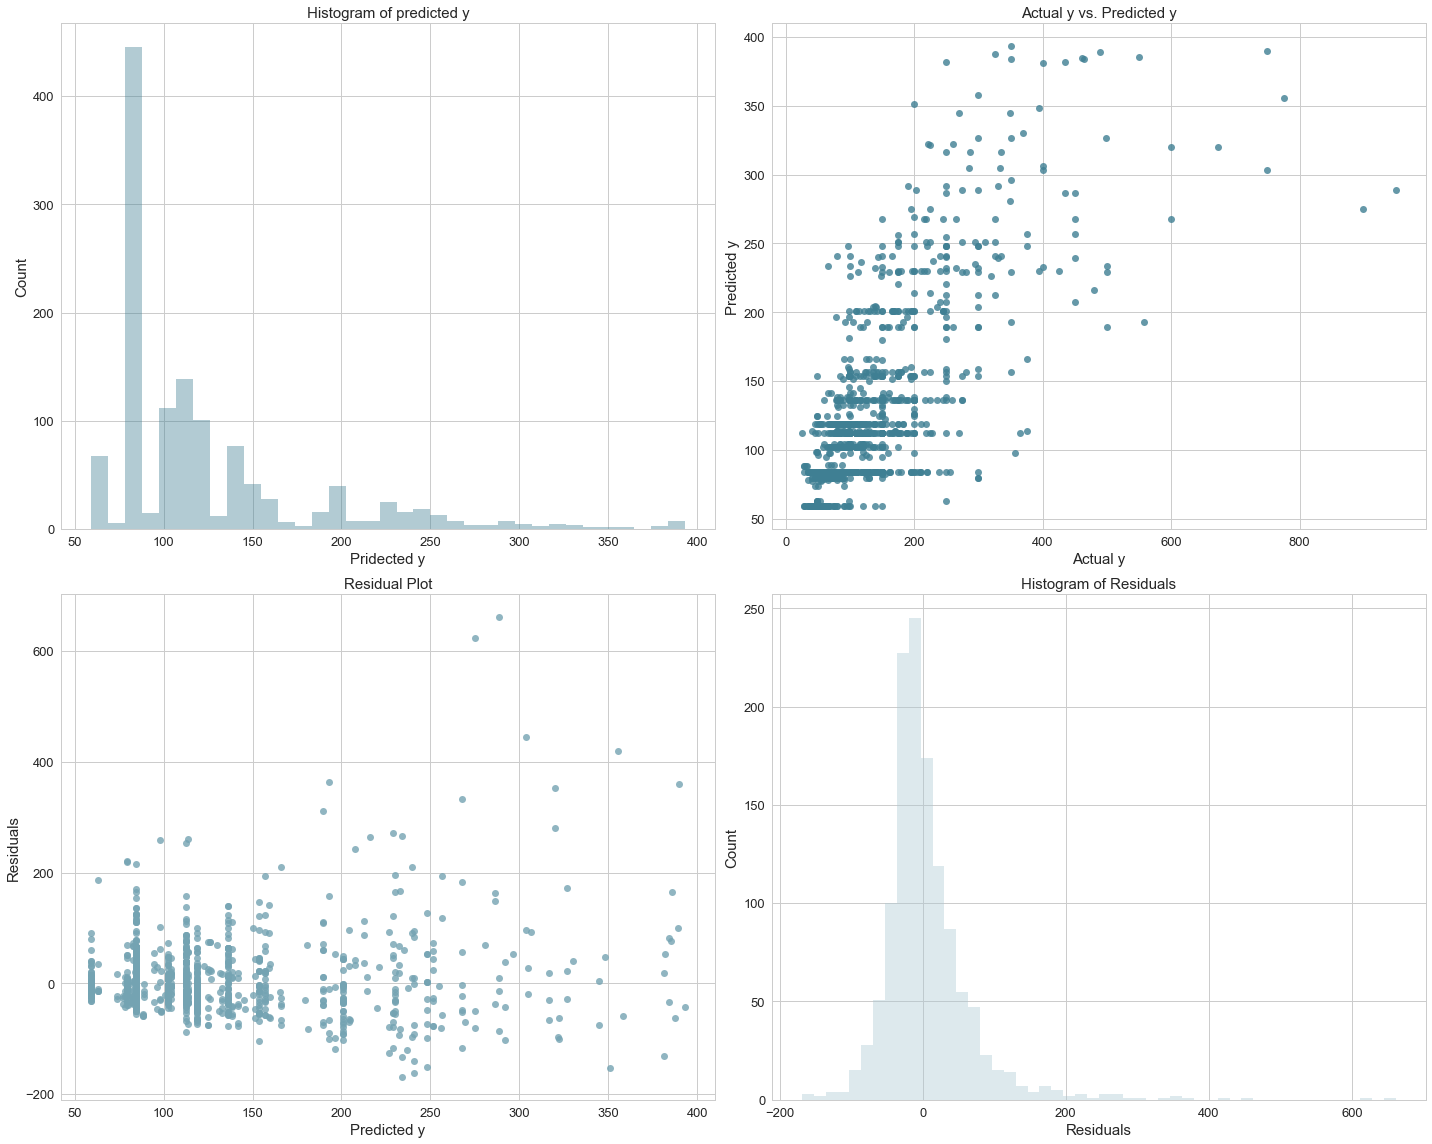

In [21]:
X, y = get_X_y(df, ['accommodates', 'bathrooms', 'bedrooms'], 'price')

y_test, y_pred_knn = KNN(X, y, df)

There are some actual price > 600 while predicted price is less than 400. Let's take a look at these data:

In [22]:
df[(df.price > 600) & (df.price_pred_knn < 400)]

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio,price_pred_knn
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.200000,2.444444,381.936170
19,700.0,81,14,9,0,10,3.5,5.0,5.0,4,1,0,250.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.000000,2.857143,393.148936
239,749.0,16,8,9,0,8,3.5,3.0,3.0,4,4,1,199.000000,4,East Queen Anne,"Poly((12375.1, 25497.4) ...)",2.666667,2.285714,303.510638
319,680.0,79,2,2,0,6,3.0,3.0,3.0,4,6,0,275.000000,4,Wallingford,"Poly((15348.5, 29727.2) ...)",2.000000,2.000000,264.319149
565,775.0,83,8,2,0,8,4.0,4.0,6.0,4,6,2,100.000000,4,Westlake,"Poly((13562.9, 22567) ...)",2.000000,2.000000,355.489362
1208,999.0,4,0,0,0,4,1.0,1.0,1.0,4,1,1,85.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",4.000000,4.000000,112.404255
1279,899.0,4,15,0,0,10,2.0,3.0,4.0,4,1,2,159.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",3.333333,5.000000,274.978723
1298,700.0,4,0,7,0,8,2.5,2.0,4.0,4,4,2,150.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",4.000000,3.200000,280.893617
1312,700.0,4,0,7,0,8,2.0,2.0,4.0,4,4,2,150.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",4.000000,4.000000,212.808511
2518,750.0,61,1,9,0,10,4.0,6.0,7.0,4,8,2,300.000000,4,Portage Bay,"Poly((15644.1, 26391.1) ...)",1.666667,2.500000,389.829787


In [23]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.classes_ = np.load('../Label Encoder/property_type.npy')
print(le.inverse_transform(0))
print(le.inverse_transform(2))
print(le.inverse_transform(7))
print(le.inverse_transform(9))

Apartment
Boat
Condominium
House


Eight of them are of property type house. Two of them are of property type aparment, two of them are condo and the rest two are boat.

Other than eight out of 14 of them are houses, the rest properties seem normal. Nothing really showed why their price is higher. We can add property type into next iteration.

#### Random Forest

In [24]:
def RandomForest(X, y, df):
    steps = [('scaler', StandardScaler())]
    steps = [('rf', RandomForestRegressor(random_state = 42))]
    param_grid = {'rf__n_estimators': np.arange(10, 100, 10),
                  'rf__max_depth' : np.arange(10, 100, 10)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model: RandomForest')
    print('    Best Params:', cv.best_params_)

    y_pred_rf = cv.predict(X_test)
    
    score_and_plot(y_test, y_pred_rf)
        
    df['price_pred_rf'] = cv.predict(X)
    
    return (y_test, y_pred_rf)

Model: RandomForest
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 80}
    MSE is:  4376.31034807
    RMSE is:  66.1536873354


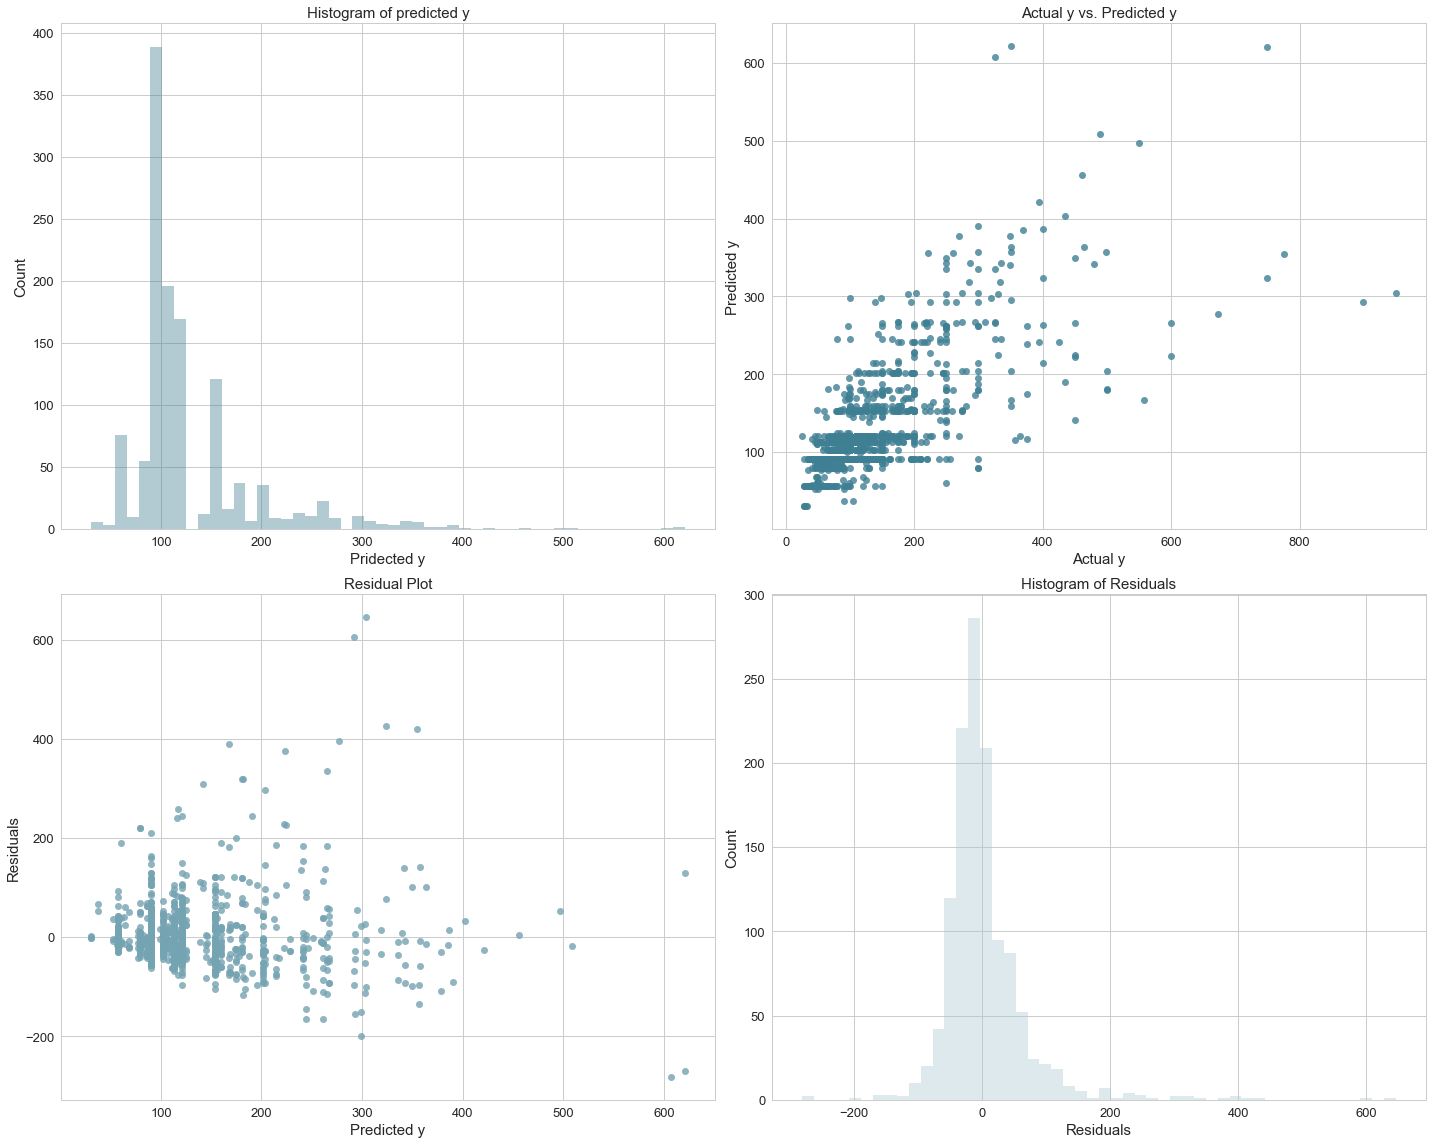

In [25]:
X, y = get_X_y(df, ['accommodates', 'bathrooms', 'bedrooms'], 'price')

y_test, y_pred_rf = RandomForest(X, y, df)

There are also some actual price > 600 while predicted price is less than 400. Let's take a look at these data:

In [26]:
df[(df.price > 600) & (df.price_pred_rf < 400)]

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio,price_pred_knn,price_pred_rf
239,749.0,16,8,9,0,8,3.5,3.0,3.0,4,4,1,199.000000,4,East Queen Anne,"Poly((12375.1, 25497.4) ...)",2.666667,2.285714,303.510638,323.884201
319,680.0,79,2,2,0,6,3.0,3.0,3.0,4,6,0,275.000000,4,Wallingford,"Poly((15348.5, 29727.2) ...)",2.000000,2.000000,264.319149,322.496131
565,775.0,83,8,2,0,8,4.0,4.0,6.0,4,6,2,100.000000,4,Westlake,"Poly((13562.9, 22567) ...)",2.000000,2.000000,355.489362,354.185960
1208,999.0,4,0,0,0,4,1.0,1.0,1.0,4,1,1,85.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",4.000000,4.000000,112.404255,120.582778
1279,899.0,4,15,0,0,10,2.0,3.0,4.0,4,1,2,159.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",3.333333,5.000000,274.978723,292.431994
1312,700.0,4,0,7,0,8,2.0,2.0,4.0,4,4,2,150.000000,4,Belltown,"Poly((11382.3, 20871.9) ...)",4.000000,4.000000,212.808511,335.739097
2868,673.0,9,1,9,0,16,2.0,6.0,9.0,4,13,2,300.000000,4,First Hill,"Poly((15893.4, 18831.1) ...)",2.666667,8.000000,320.127660,276.875188
3122,1000.0,65,10,9,0,4,1.0,2.0,2.0,4,1,0,61.710904,4,Roosevelt,"Poly((16853.6, 32716.3) ...)",2.000000,4.000000,135.978723,153.405122
3443,950.0,73,26,9,0,6,3.5,3.0,3.0,4,6,2,61.710904,4,Magnolia,"Poly((5703.04, 29769.1) ...)",2.000000,1.714286,288.723404,304.069448


These outliers appears in KNN model as well. Looks like these are real outliers that neither KNN nor random forest can predict them well. 

We can compare their actual vs. predicted price side-by-side:

In [27]:
df.head()

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio,price_pred_knn,price_pred_rf
0,85.0,81,14,0,0,4,1.0,1.0,1.0,4,2,1,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000,112.404255,120.582778
1,150.0,81,14,0,0,4,1.0,1.0,1.0,4,1,2,40.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000,112.404255,120.582778
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.2,2.444444,381.936170,835.737500
3,100.0,81,14,0,0,3,1.0,0.0,2.0,4,1,0,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",6.0,3.000000,104.021277,106.659309
4,450.0,81,14,9,0,6,2.0,3.0,3.0,4,6,2,125.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.0,3.000000,230.234043,240.905980


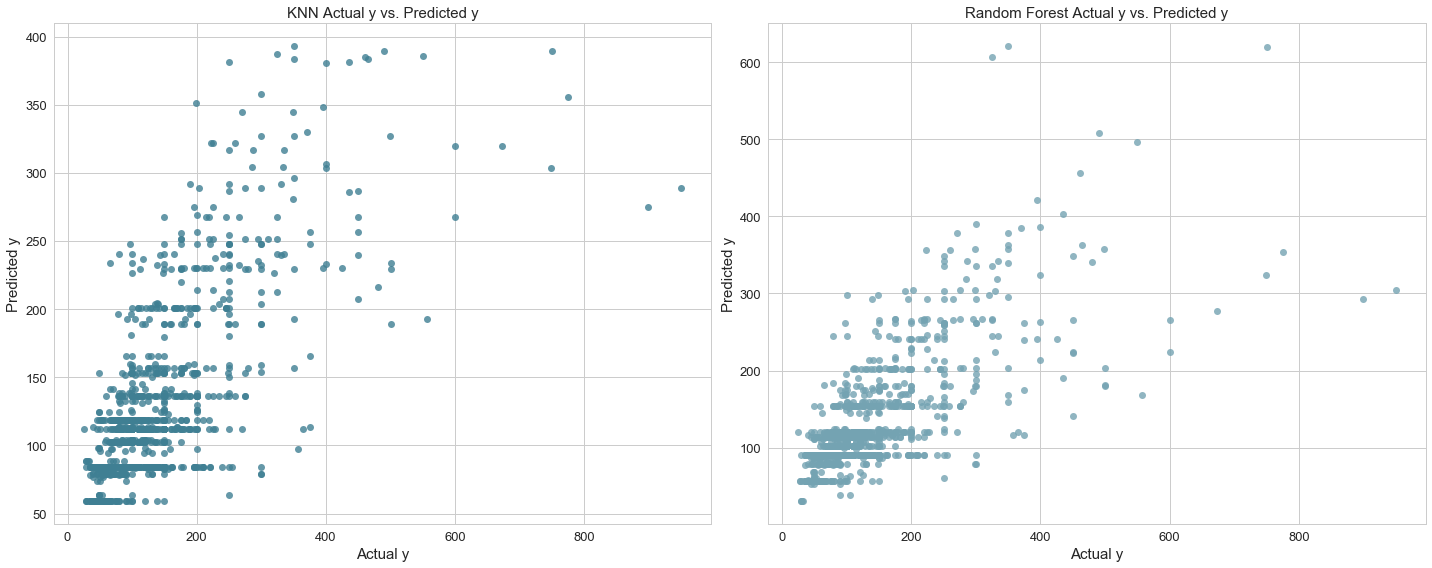

In [28]:
fontsize = 15

fig, axes = get_sub_plots(2, 2)
sns.regplot(y_test, y_pred_knn, fit_reg = False, ax = axes[0])
axes[0].set_title('KNN Actual y vs. Predicted y', fontsize = fontsize)
axes[0].set_xlabel('Actual y', fontsize = fontsize)
axes[0].set_ylabel('Predicted y', fontsize = fontsize)
    
sns.regplot(y_test, y_pred_rf, fit_reg = False, ax = axes[1])
axes[1].set_title('Random Forest Actual y vs. Predicted y', fontsize = fontsize)
axes[1].set_xlabel('Actual y', fontsize = fontsize)
axes[1].set_ylabel('Predicted y', fontsize = fontsize)
            
fig.tight_layout()    
plt.show()

Looks like KNN could not predicted properties with higher price well.

Random forest can at least prdict some of them.

### Add More Features & Engineer Features

After analyzing each model, let's add property type into features based on the above analysis.

As property type is categorical data, we need to tranform them using onehot encoder first.

In [29]:
df_property_type_onehot = pd.get_dummies(df['property_type'], prefix = 'property_type')
df_property_type_onehot.head()

,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [30]:
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot], axis = 1)
X = df_X.as_matrix()
y = df['price'].as_matrix()

Then we put the new X & y into KNN & random forest:

#### K-Nearest Neighbors

Model: KNN
    Best Params: {'knn__n_neighbors': 17}
    MSE is:  4387.91529093
    RMSE is:  66.2413412525


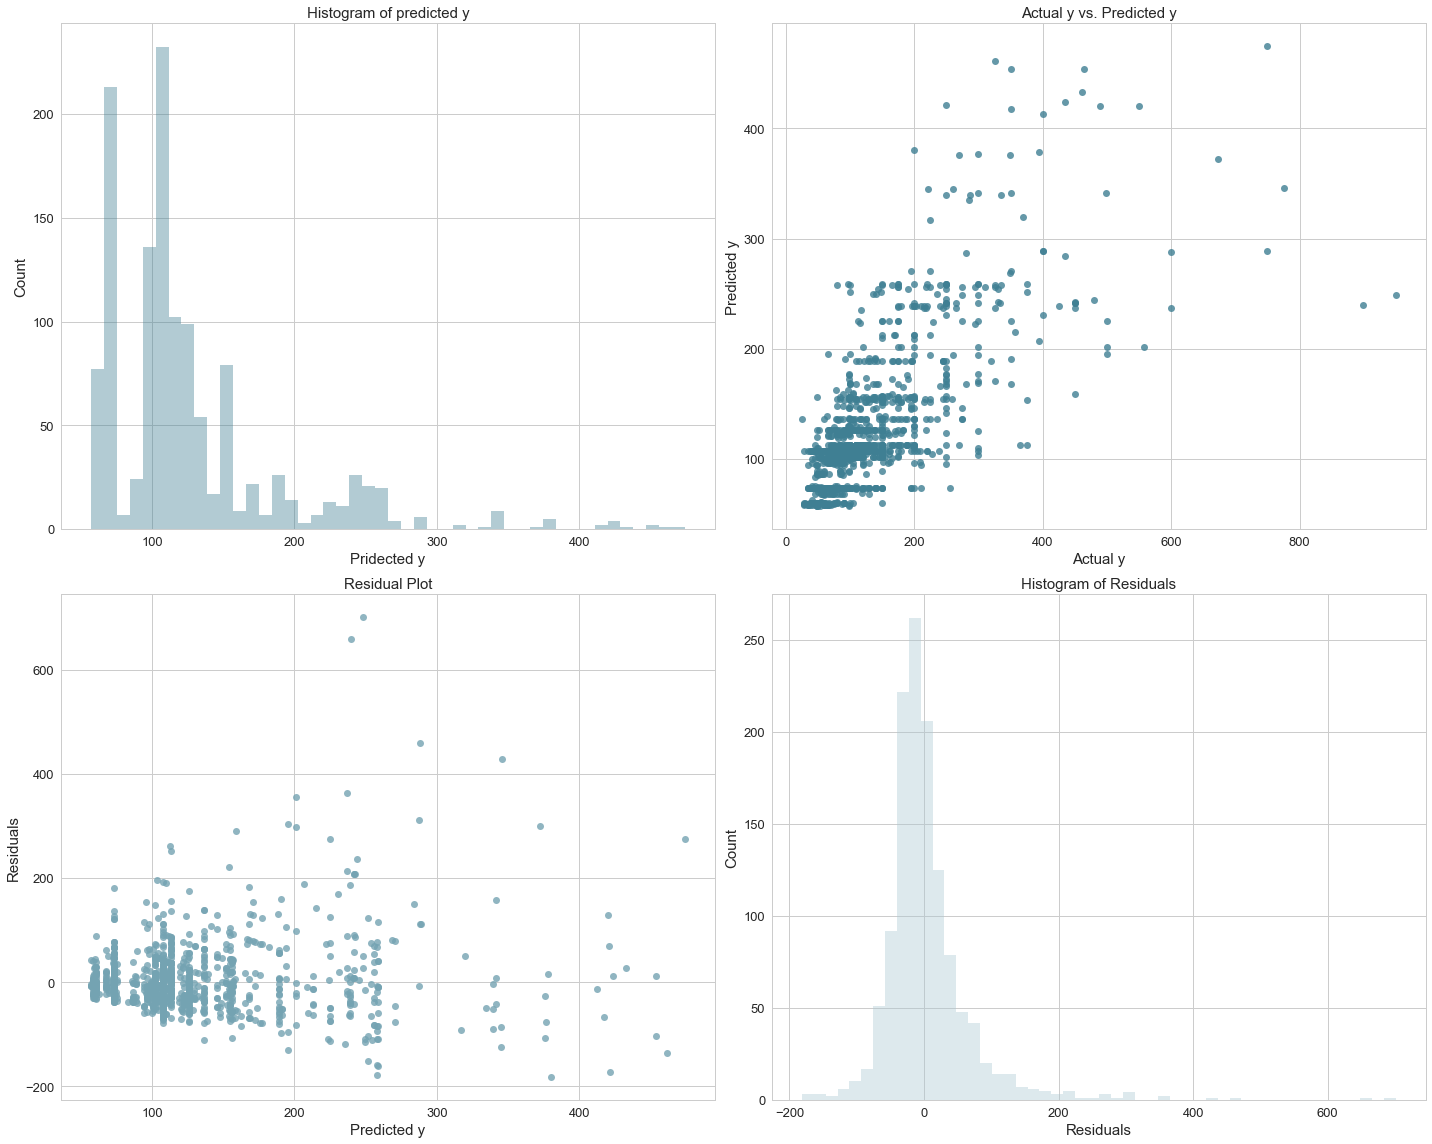

In [31]:
y_test, y_pred_knn = KNN(X, y, df)

#### Random Forest

Model: RandomForest
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 80}
    MSE is:  4283.23046611
    RMSE is:  65.4463938358


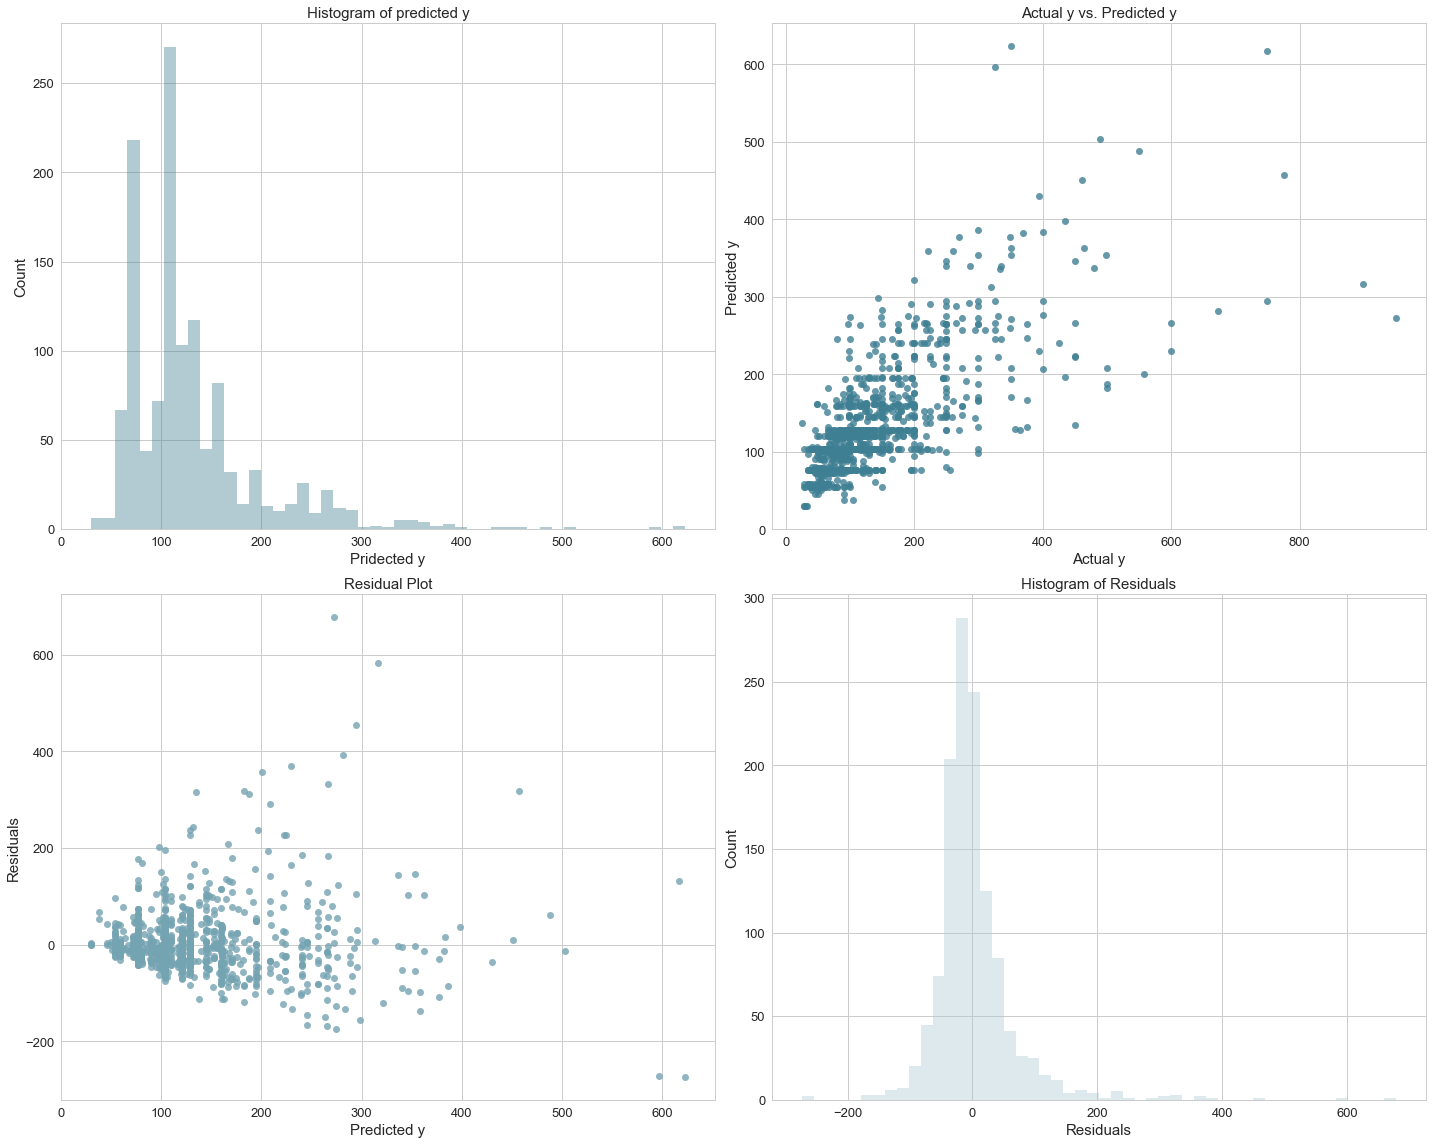

In [32]:
y_test, y_pred_rf = RandomForest(X, y, df)

W/o property type, KNN has RMSE **65.7802492126**, random forest has RMSE **66.1536873354**.

After adding property type, KNN gives **66.2413412525**, random forest gives **65.4463938358**.

Looks like adding **property type does improve random forest results**.

Also based on the exploratory data analysis, neighborgood would also affect price. Let's add it into feature.

In [33]:
df_neighbourhood_cleansed_onehot = pd.get_dummies(df['neighbourhood_cleansed'], prefix = 'neighbourhood_cleansed')
df_neighbourhood_cleansed_onehot.head()

,neighbourhood_cleansed_0,neighbourhood_cleansed_1,neighbourhood_cleansed_2,neighbourhood_cleansed_3,neighbourhood_cleansed_4,neighbourhood_cleansed_5,neighbourhood_cleansed_6,neighbourhood_cleansed_7,neighbourhood_cleansed_8,neighbourhood_cleansed_9,...,neighbourhood_cleansed_77,neighbourhood_cleansed_78,neighbourhood_cleansed_79,neighbourhood_cleansed_80,neighbourhood_cleansed_81,neighbourhood_cleansed_82,neighbourhood_cleansed_83,neighbourhood_cleansed_84,neighbourhood_cleansed_85,neighbourhood_cleansed_86
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot, df_neighbourhood_cleansed_onehot], axis = 1)
X = df_X.as_matrix()
y = df['price'].as_matrix()

#### K-Nearest Neighbors

Model: KNN
    Best Params: {'knn__n_neighbors': 4}
    MSE is:  5381.47972973
    RMSE is:  73.3585695725


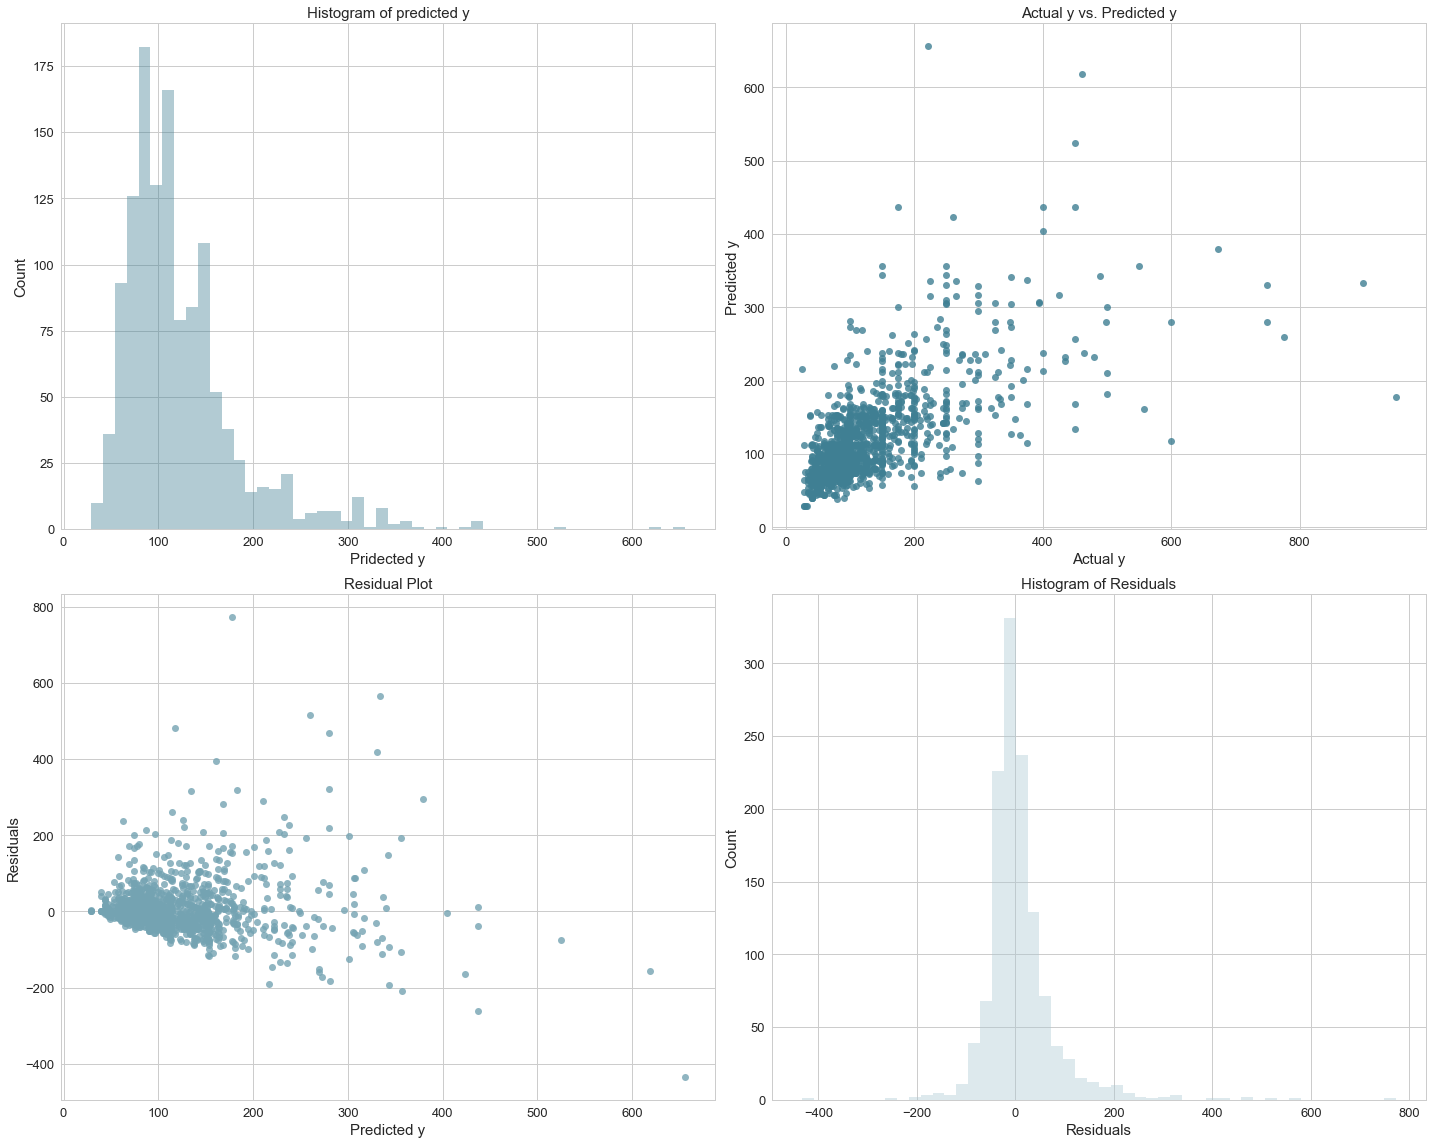

In [35]:
y_test, y_pred_knn = KNN(X, y, df)

#### Random Forest

Model: RandomForest
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 90}
    MSE is:  4034.55782787
    RMSE is:  63.5181692736


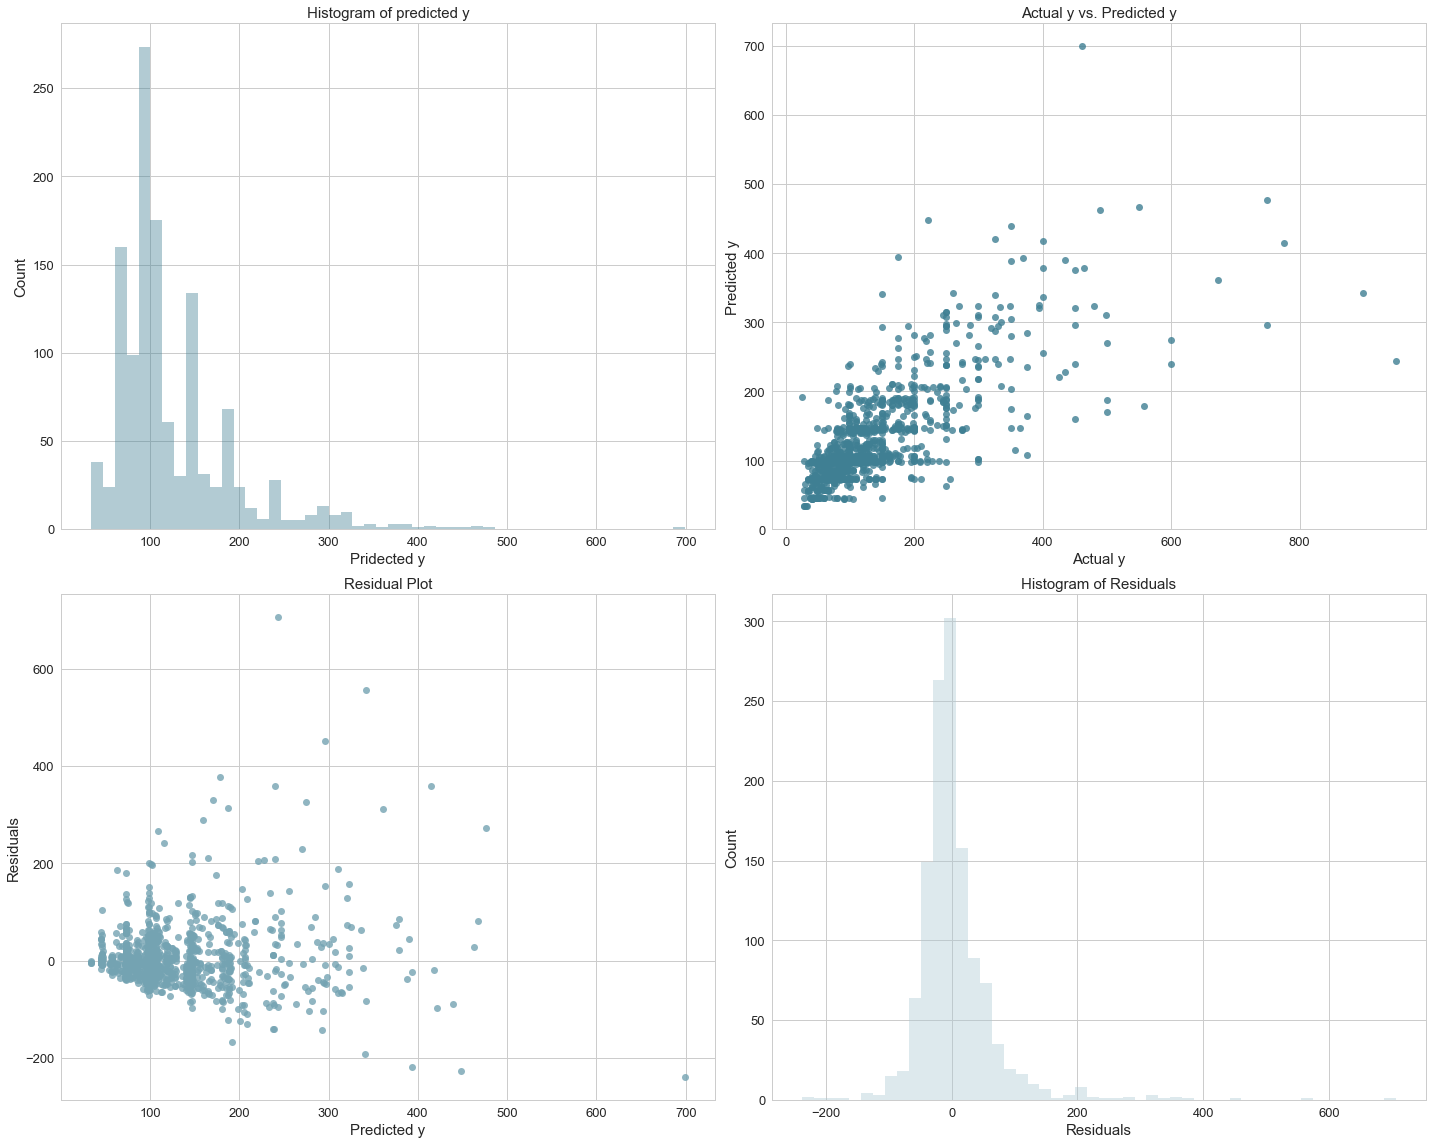

In [36]:
y_test, y_pred_rf = RandomForest(X, y, df)

By adding neighborhood, we can further improve random forest results a little bit. RMSE is improved from 65.4463938358 to 63.5181692736.

**However KNN results degrade a lot. By inspecting the KNN models, number of 'n_neighbors' became smaller & smaller when we add more features.**

**Note that KNN depends on similar neighbor data points to get better prediction results. It looks like when we add more features, it increased dementinality. W/ the curse of dementionality. Number of similar data points seems becoming less, so RMSE started to get higher.**

**On the other hand, random forest by nature automatically select useful features for splitting so did not have this issue.**

#### Gradient Boosting

Lastly, we try the popular gradient boosting model w/ XGBoost, which is one of the most popular gradient boosting package.

In [37]:
import xgboost as xgb

def GB(X, y, df):
    steps = [('scaler', StandardScaler())]
    steps += [('gb', xgb.XGBRegressor(objective = 'reg:linear', seed = 123))]
    
    param_grid = {'gb__n_estimators': np.arange(1, 50)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model: Gradient Boosting')
    print('    Best Params:', cv.best_params_)

    y_pred_gb = cv.predict(X_test)
    score_and_plot(y_test, y_pred_gb)

    df['price_pred_gb'] = cv.predict(X)
    
    return (y_test, y_pred_gb)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Model: Gradient Boosting
    Best Params: {'gb__n_estimators': 49}
    MSE is:  4064.00915392
    RMSE is:  63.749581598


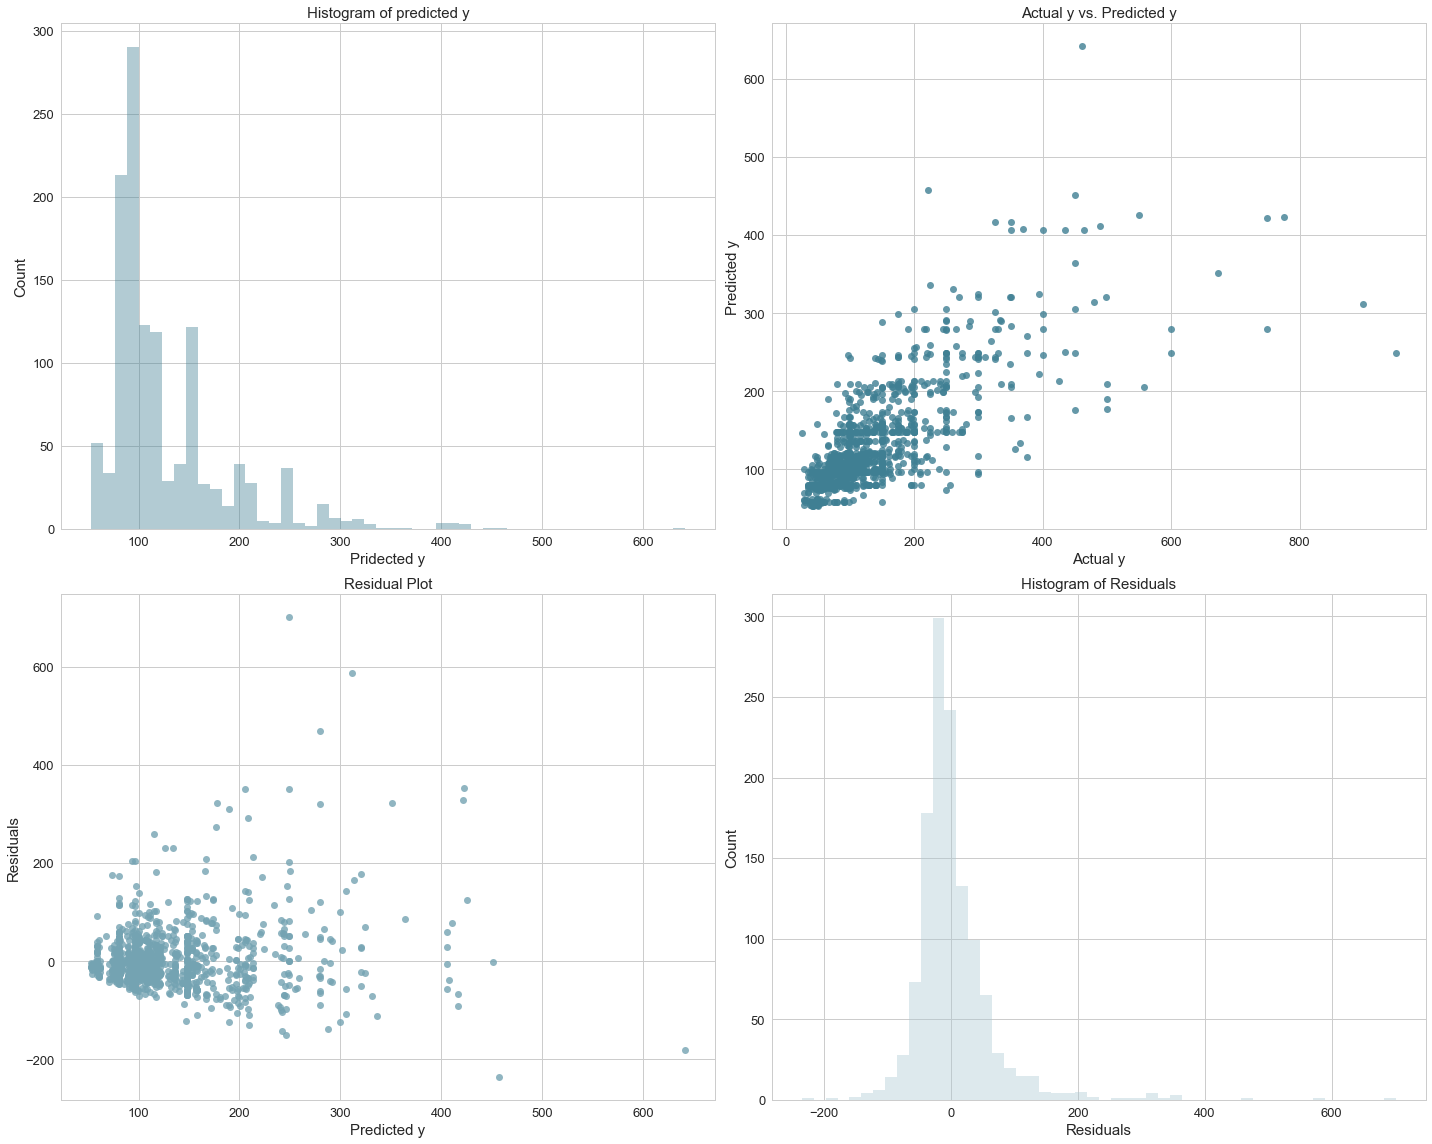

In [38]:
y_test, y_pred_knn = GB(X, y, df)

Let's tune more parameters:

In [39]:
def GB_more_params(X, y, df):
    steps = [('scaler', StandardScaler())]
    steps += [('gb', xgb.XGBRegressor(objective = 'reg:linear', seed = 123))]
    
    param_grid = {'gb__n_estimators': np.arange(1, 50), 'gb__learning_rate' : [0.01, 0.1, 0.2], 'gb__max_depth': np.arange(1, 10, 1)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model: Gradient Boosting')
    print('    Best Params:', cv.best_params_)

    y_pred_gb = cv.predict(X_test)
    score_and_plot(y_test, y_pred_gb)

    df['price_pred_gb'] = cv.predict(X)
    
    return (y_test, y_pred_gb)

Model: Gradient Boosting
    Best Params: {'gb__learning_rate': 0.2, 'gb__max_depth': 4, 'gb__n_estimators': 40}
    MSE is:  3988.94610857
    RMSE is:  63.1581040609


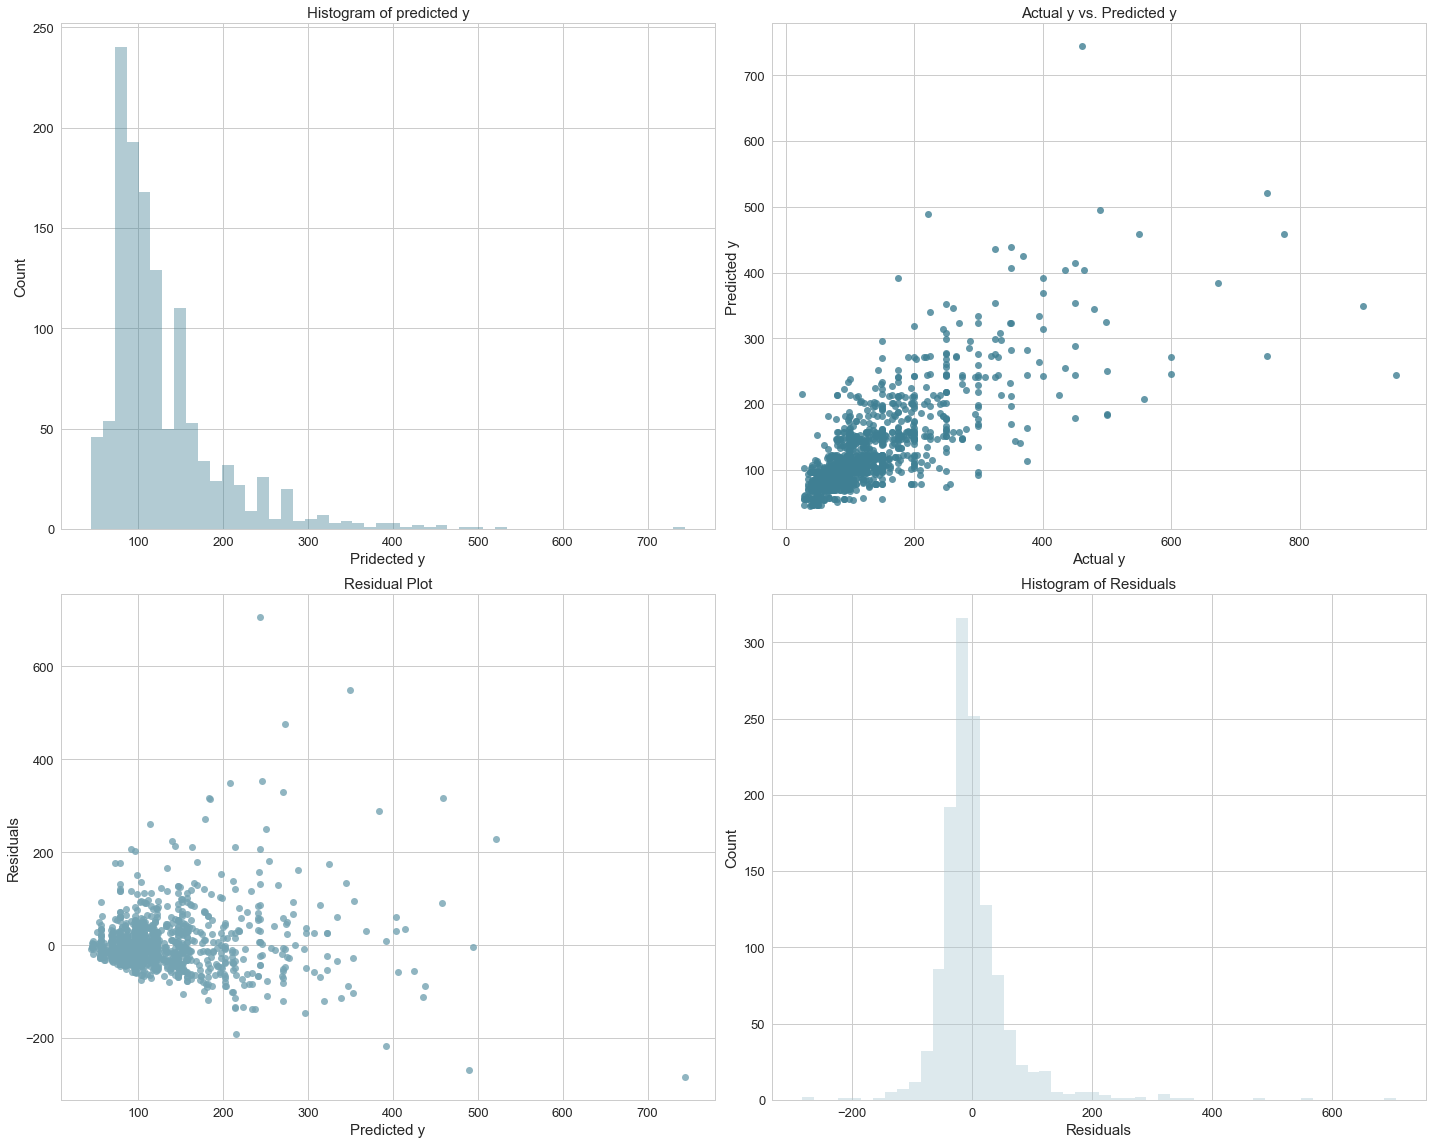

In [40]:
y_test, y_pred_knn = GB_more_params(X, y, df)

By tuning more hyperparameters, RMSE is improved from **63.749581598** to **63.1581040609**.

Note that previously best RMSE is **63.5181692736**, based on **random forest**.
So **gradient boosting now gives even better results than random forest**.

### Conclusion
1. We tried 6 different models on Airbnb listing price prediction
 * K-Nearest Neighbors
 * Linear Regression
 * Ridge Regression
 * Lasso Regression
 * Random Forest
 * Gradient Boosting
2. KNN & random forest outperforms linear regression models. After adding more features, random forest performs better than KNN.
 * If looking at KNN results, after adding more features, best parameter for n_neighbors became less. It might be because KNN depends on similar neighbor data points to get better prediction results. When adding more features, it increased dementinality. W/ the curse of dementionality. Number of similar data points seems becoming less, so RMSE started to get higher.
 * On the other hand, random forest by nature automatically select useful features when splitting so did not have this issue.
3. Linear regression models did not perform well because here are less datapoints with price above about 300 and looks like they have a different linear relationship. For this piecewise linear regression is sometimes used.
4. Gradient boosting model gives the BEST RMSE compared to all other models.

### Next Steps
While we already tried several models, there are still some interesting future works:
1. Apply NLP on Airbnb reviews for better listing price prediction.
2. Apply models on other cities or training model on other cities.
3. Apply piecewise linear regression.